# Coding Task 1

Experiment PET on Yelp (Table 1) and create your own verbalizers and
patterns.

- Compare your results with the ones PET achieves in the original paper.
- Does/How the patterns/verbalizers affect the downstream results?

References - 
1. Paper - https://arxiv.org/abs/2001.07676
2. Official Repo - https://github.com/timoschick/pet

Written by: 
- Asaf Dahan
- Omer Dodi

### Environment prep & imports

In [ ]:
!git clone https://github.com/timoschick/pet.git ./pet_repo

fatal: destination path './pet_repo' already exists and is not an empty directory.


In [ ]:
!pip install transformers
!pip install datasets
!pip install jsonpickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys
sys.path.append('/content/pet_repo')

# Basics
import os
import gc
import pandas as pd
import torch

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Transformers
import transformers
import datasets
import pet

### Loading the dataset and reviewing it

In [ ]:
dataset = datasets.load_dataset('yelp_review_full')

Reusing dataset yelp_review_full (/root/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

##### Printing a couple of examples

In [ ]:
for i in range(5):
  print(dataset['train'][i])

{'label': 4, 'text': "dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank."}
{'label': 1, 'text': "Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  Y

##### Prepare the input CSV files for pet module
Accorfing to the paper
- Train data - first x / |L| samples per label from the training set
- Eval data - original test set
- Unlabelled samples - Collect 1k examples per label from the training set (which is not used for training) and remove labels.

We originally started with 10K samples per label as the paper mentioned but due to hardware limitations and long training time we only sampled 1k per label eventually.

In [ ]:
train_set_sizes = [10, 50, 100, 1000]
dev_samples_per_label = 1000

train_data = [i for i in dataset['train']]
test_data = [i for i in dataset['test']]

train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

try:
  os.mkdir('/content/datasets')
except OSError as e:
  print(f"OS Error on dir creation - {e}")


try:
  os.mkdir('/content/outputs')
except OSError as e:
  print(f"OS Error on dir creation - {e}")

try:
  os.mkdir('/content/cache')
except OSError as e:
  print(f"OS Error on dir creation - {e}")


# Fix label to 1-5 in order to work with PETYelp wrapper
train_df['label'] = train_df['label'].map(lambda x: x+1) 
test_df['label'] = test_df['label'].map(lambda x: x+1)


for train_set_size in train_set_sizes:
  train_dfs_per_label = []
  train_samples_per_label = int(train_set_size / 5)
  
  # Save as CSV for PET
  for label in range(1, 6):
    cur_df = train_df[train_df.label==label]
    train_dfs_per_label.append(cur_df.head(train_samples_per_label))
  
  cur_train = pd.concat(train_dfs_per_label)

  cur_train.to_csv(f'/content/datasets/train_{train_set_size}_samples.csv', index=False, header=False)

test_dfs_per_label = []
unlabelled_dfs_per_label = []

for label in range(1,6):
    # Unlabelled dataset
    cur_df = train_df[train_df.label==label]
    unlabelled_dfs_per_label.append(cur_df.tail(dev_samples_per_label))

    # Dev dataset
    cur_dev_df = test_df[test_df.label==label]
    test_dfs_per_label.append(cur_dev_df.head(dev_samples_per_label))

unlabelled_df = pd.concat(unlabelled_dfs_per_label)
test_df = pd.concat(test_dfs_per_label)

unlabelled_df.to_csv('/content/datasets/unlabeled.csv', index=False, header=False)
test_df.to_csv('/content/datasets/test.csv', index=False, header=False)

OS Error on dir creation - [Errno 17] File exists: '/content/datasets'
OS Error on dir creation - [Errno 17] File exists: '/content/outputs'
OS Error on dir creation - [Errno 17] File exists: '/content/cache'


##### Check labels distribution

In [ ]:
train_df.label.value_counts()

5    130000
2    130000
4    130000
1    130000
3    130000
Name: label, dtype: int64

In [ ]:
test_df.label.value_counts()

1    1000
2    1000
3    1000
4    1000
5    1000
Name: label, dtype: int64

Seems to be perfectly balanced.

In [ ]:
print(f"Train text duplicates: {any(train_df.text.value_counts().values > 1)}")
print(f"Test text duplicates: {any(test_df.text.value_counts().values > 1)}")

Train text duplicates: False
Test text duplicates: False


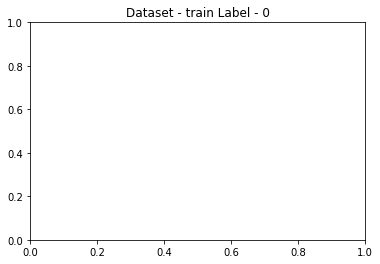

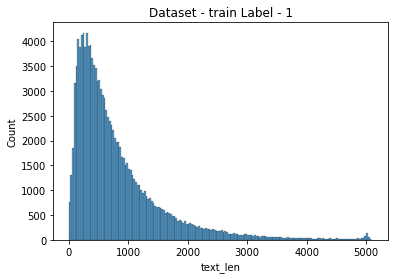

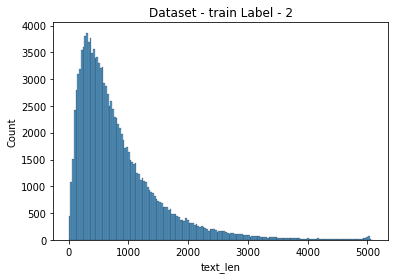

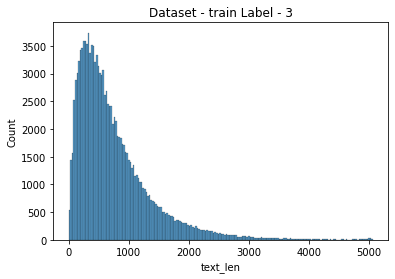

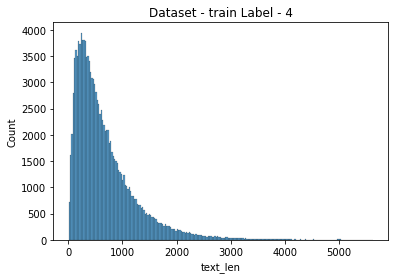

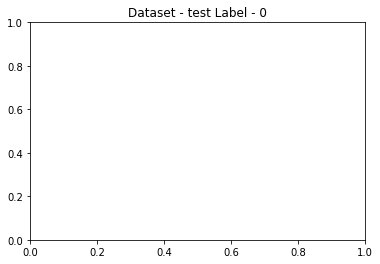

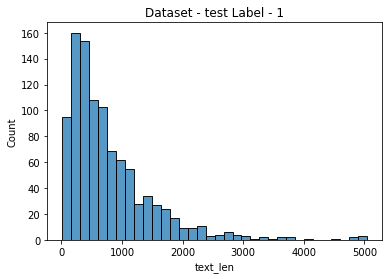

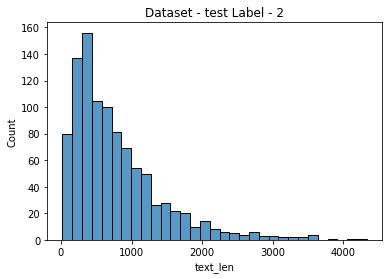

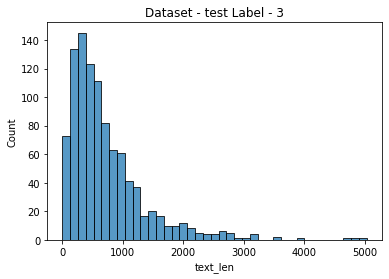

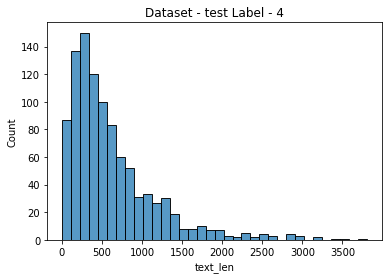

In [ ]:
# Print text length historgram per label
train_df['text_len'] = train_df.text.map(lambda x: len(x))
test_df['text_len'] = test_df.text.map(lambda x: len(x))

for ds in ['train', 'test']:
  df = train_df if ds == 'train' else test_df

  for label in range(5):
    cur_df = df[df.label == label]
    sns.histplot(data=cur_df, x='text_len')
    plt.title(f"Dataset - {ds} Label - {label}")
    plt.show()

In [ ]:
# Clean memory from dataframes
del train_df
del test_df

gc.collect()

21108

### Training

#### Infra and wrapping the PET package for our experiments

In [ ]:
from typing import Tuple
from pet.wrapper import WrapperConfig
from pet.tasks import PROCESSORS, load_examples, UNLABELED_SET, TRAIN_SET, DEV_SET, TEST_SET, METRICS, DEFAULT_METRICS
from pet.utils import eq_div
from pet.wrapper import WRAPPER_TYPES, MODEL_CLASSES, SEQUENCE_CLASSIFIER_WRAPPER, WrapperConfig

In [ ]:
import csv
import os
from typing import List

from pet.task_helpers import MultiMaskTaskHelper
from pet.tasks import DataProcessor, PROCESSORS, TASK_HELPERS
from pet.utils import InputExample


class YelpFullProcessor(DataProcessor):
    """
    Custom data processor.
    I've created it in order to use the Yelp-Full dataset we loaded with HuggingFace.
    """

    # Set this to the name of the task
    TASK_NAME = "yelp-full"

    # Set this to the name of the file containing the train examples
    TRAIN_FILE_NAME = "train_1000_samples.csv"

    # Set this to the name of the file containing the dev examples
    DEV_FILE_NAME = "test.csv"

    # Set this to the name of the file containing the test examples
    TEST_FILE_NAME = "not_important.csv"

    # Set this to the name of the file containing the unlabeled examples
    UNLABELED_FILE_NAME = "unlabeled.csv"

    # Set this to a list of all labels in the train + test data
    LABELS = ['1', '2', '3', '4', '5']

    # Set this to the column of the train/test csv files containing the input's text a
    TEXT_A_COLUMN = 1

    # Set this to the column of the train/test csv files containing the input's text b or to -1 if there is no text b
    TEXT_B_COLUMN = -1

    # Set this to the column of the train/test csv files containing the input's gold label
    LABEL_COLUMN = 0

    def get_train_examples(self, data_dir: str) -> List[InputExample]:
        """
        This method loads train examples from a file with name `TRAIN_FILE_NAME` in the given directory.
        :param data_dir: the directory in which the training data can be found
        :return: a list of train examples
        """
        return self._create_examples(os.path.join(data_dir, YelpFullProcessor.TRAIN_FILE_NAME), "train")

    def get_dev_examples(self, data_dir: str) -> List[InputExample]:
        """
        This method loads dev examples from a file with name `DEV_FILE_NAME` in the given directory.
        :param data_dir: the directory in which the dev data can be found
        :return: a list of dev examples
        """
        return self._create_examples(os.path.join(data_dir, YelpFullProcessor.DEV_FILE_NAME), "dev")

    def get_test_examples(self, data_dir) -> List[InputExample]:
        """
        This method loads test examples from a file with name `TEST_FILE_NAME` in the given directory.
        :param data_dir: the directory in which the test data can be found
        :return: a list of test examples
        """
        return self._create_examples(os.path.join(data_dir, YelpFullProcessor.TEST_FILE_NAME), "test")

    def get_unlabeled_examples(self, data_dir) -> List[InputExample]:
        """
        This method loads unlabeled examples from a file with name `UNLABELED_FILE_NAME` in the given directory.
        :param data_dir: the directory in which the unlabeled data can be found
        :return: a list of unlabeled examples
        """
        return self._create_examples(os.path.join(data_dir, YelpFullProcessor.UNLABELED_FILE_NAME), "unlabeled")

    def get_labels(self) -> List[str]:
        """This method returns all possible labels for the task."""
        return YelpFullProcessor.LABELS

    def _create_examples(self, path, set_type, max_examples=-1, skip_first=0):
        """Creates examples for the training and dev sets."""
        examples = []

        with open(path) as f:
            reader = csv.reader(f, delimiter=',')
            for idx, row in enumerate(reader):
                guid = "%s-%s" % (set_type, idx)
                label = row[YelpFullProcessor.LABEL_COLUMN]
                text_a = row[YelpFullProcessor.TEXT_A_COLUMN]
                text_b = row[YelpFullProcessor.TEXT_B_COLUMN] if YelpFullProcessor.TEXT_B_COLUMN >= 0 else None
                example = InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label)
                examples.append(example)

        return examples


# register the processor for this task with its name
PROCESSORS['yelp-full'] = YelpFullProcessor

In [ ]:
def load_pet_configs(conf) -> Tuple[WrapperConfig, pet.TrainConfig, pet.EvalConfig]:
    """
    Load the model, training and evaluation configs for PET from the given command line arguments.
    """
    model_cfg = WrapperConfig(model_type=conf['model_type'], model_name_or_path=conf['model_name_or_path'],
                              wrapper_type='mlm', task_name=conf['task_name'], label_list=conf['label_list'],
                              max_seq_length=conf['max_seq_len'], verbalizer_file=conf['verbalizer_file'],
                              cache_dir=conf['cache_dir'])

    train_cfg = pet.TrainConfig(device=conf['device'], per_gpu_train_batch_size=conf['per_gpu_batch_size'],
                                per_gpu_unlabeled_batch_size=conf['per_gpu_batch_size'], n_gpu=conf['n_gpu'],
                                num_train_epochs=conf['train_epochs'], max_steps=-1, gradient_accumulation_steps=1,
                                weight_decay=conf['weight_decay'], learning_rate=conf['lr'],
                                adam_epsilon=conf['adam_epsilon'], warmup_steps=conf['warmup_steps'],
                                max_grad_norm=conf['max_grad_norm'], lm_training=False, alpha=conf['alpha'])

    eval_cfg = pet.EvalConfig(device=conf['device'], n_gpu=conf['n_gpu'], metrics=conf['metrics'],
                              per_gpu_eval_batch_size=conf['per_gpu_batch_size'],
                              decoding_strategy='default', priming=False)

    return model_cfg, train_cfg, eval_cfg



def load_sequence_classifier_configs(conf) -> Tuple[WrapperConfig, pet.TrainConfig, pet.EvalConfig]:
    """
    Load the model, training and evaluation configs for a regular sequence classifier from the given command line
    arguments. This classifier can either be used as a standalone model or as the final classifier for PET/iPET.
    """
    model_cfg = WrapperConfig(model_type=conf['model_type'], model_name_or_path=conf['model_name_or_path'],
                              wrapper_type=SEQUENCE_CLASSIFIER_WRAPPER, task_name=conf['task_name'],
                              label_list=conf['label_list'], max_seq_length=conf['max_seq_len'],
                              verbalizer_file=conf['verbalizer_file'], cache_dir=conf['cache_dir'])

    train_cfg = pet.TrainConfig(device=conf['device'], per_gpu_train_batch_size=conf['per_gpu_batch_size'],
                                per_gpu_unlabeled_batch_size=conf['per_gpu_batch_size'], n_gpu=conf['n_gpu'],
                                num_train_epochs=conf['train_epochs'], max_steps=-1,
                                temperature=conf['temperature'], gradient_accumulation_steps=1,
                                weight_decay=conf['weight_decay'], learning_rate=conf['lr'],
                                adam_epsilon=conf['adam_epsilon'], warmup_steps=conf['warmup_steps'],
                                max_grad_norm=conf['max_grad_norm'], use_logits=True)

    eval_cfg = pet.EvalConfig(device=conf['device'], n_gpu=conf['n_gpu'], metrics=conf['metrics'],
                              per_gpu_eval_batch_size=conf['per_gpu_batch_size'])

    return model_cfg, train_cfg, eval_cfg

We will add an additional model class for distilbert in order to run in reasonable time due to hardware limitations.

In [ ]:
from transformers import DistilBertConfig, DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertForMaskedLM
from pet.wrapper import MODEL_CLASSES, MLM_WRAPPER

base_model_type = "distilbert"
base_model_name = "distilbert-base-uncased"
MODEL_CLASSES[base_model_type] = {
    'config': DistilBertConfig,
    'tokenizer': DistilBertTokenizer,
    SEQUENCE_CLASSIFIER_WRAPPER: DistilBertForSequenceClassification,
    MLM_WRAPPER: DistilBertForMaskedLM
}

#### Baseline model training (default PVP pairs)

In [ ]:
import shutil

base_conf = {
  # Setup CUDA and GPU
  'device': "cuda" if torch.cuda.is_available() else "cpu",
  'n_gpu': torch.cuda.device_count(),

  # Task Specific
  'task_name': 'yelp-full',
  
  # Training args & datasets
  'train_examples': 100,
  'test_examples': -1,
  'unlabelled_examples': -1,
  'max_seq_len': 256,

  # Hyper-params
  'train_epochs': 3,
  'per_gpu_batch_size': 4,
  'temperature': 2,
  'lr': 1e-5,
  'weight_decay': 0.01,
  'adam_epsilon': 1e-8,
  'warmup_steps': 0,
  'reduction': 'wmean',
  'alpha': 0.0001,
  'max_grad_norm': 1.0,
  'seed': 42,

  # Data params
  'data_dir': "/content/datasets",
  'output_dir': "/content/outputs",
  'cache_dir': "/content/cache",
  'verbalizer_file': None, # None means default pattern-verbalizers pairs (default PVPs)
  'pattern_ids': [0, 1, 2, 3], # These are the default patterns for the Yelp experiment

  # LM
  'model_type': base_model_type,
  'model_name_or_path': base_model_name
}


def run_train(conf):
  # Delete previous training outputs dir
  shutil.rmtree(conf['output_dir'])
  os.mkdir(conf['output_dir'])

  processor = PROCESSORS[conf['task_name']]()
  label_list = processor.get_labels()
  conf['label_list'] = label_list

  train_ex_per_label = eq_div(conf['train_examples'], len(conf['label_list'])) if conf['train_examples'] != -1 else -1
  test_ex_per_label = eq_div(conf['test_examples'], len(conf['label_list'])) if conf['test_examples'] != -1 else -1
  train_ex, test_ex = None, None
  eval_set = DEV_SET

  train_data = load_examples(
      conf['task_name'], conf['data_dir'], TRAIN_SET, num_examples=train_ex, num_examples_per_label=train_ex_per_label)
  eval_data = load_examples(
      conf['task_name'], conf['data_dir'], eval_set, num_examples=test_ex, num_examples_per_label=test_ex_per_label)
  unlabeled_data = load_examples(
      conf['task_name'], conf['data_dir'], UNLABELED_SET, num_examples=conf['unlabelled_examples'])

  metrics = METRICS.get(conf['task_name'], DEFAULT_METRICS)
  conf['metrics'] = metrics

  pet_model_cfg, pet_train_cfg, pet_eval_cfg = load_pet_configs(conf)
  sc_model_cfg, sc_train_cfg, sc_eval_cfg = load_sequence_classifier_configs(conf)

  # Train the model
  pet.train_pet(pet_model_cfg, pet_train_cfg, pet_eval_cfg, sc_model_cfg, sc_train_cfg, sc_eval_cfg,
                pattern_ids=conf['pattern_ids'], output_dir=conf['output_dir'],
                ensemble_repetitions=3, final_repetitions=1,
                reduction=conf['reduction'], train_data=train_data, unlabeled_data=unlabeled_data,
                eval_data=eval_data, do_train=True, do_eval=True,
                no_distillation=False, seed=conf['seed'])

In [ ]:
run_train(base_conf)

2022-06-15 08:22:57,596 - INFO - tasks - Creating features from dataset file at /content/datasets (num_examples_per_label=[20, 20, 20, 20, 20], set_type=train)
2022-06-15 08:22:57,614 - INFO - tasks - Returning 100 train examples with label dist.: [('1', 20), ('2', 20), ('3', 20), ('4', 20), ('5', 20)]
2022-06-15 08:22:57,615 - INFO - tasks - Creating features from dataset file at /content/datasets (num_examples_per_label=-1, set_type=dev)
2022-06-15 08:22:57,681 - INFO - tasks - Returning 5000 dev examples with label dist.: [('1', 1000), ('2', 1000), ('3', 1000), ('4', 1000), ('5', 1000)]
2022-06-15 08:22:57,682 - INFO - tasks - Creating features from dataset file at /content/datasets (num_examples=-1, set_type=unlabeled)
2022-06-15 08:22:57,745 - INFO - tasks - Returning 5000 unlabeled examples with label dist.: [('1', 5000)]
2022-06-15 08:23:02,899 - INFO - wrapper - Writing example 0
2022-06-15 08:23:02,907 - INFO - wrapper - --- Example 0 ---
2022-06-15 08:23:02,908 - INFO - wrapp

{"learning_rate": 3.3333333333333333e-06, "loss": 1.3549556827545166, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.27s/it]
2022-06-15 08:23:11,177 - INFO - wrapper - Writing example 0
2022-06-15 08:23:11,185 - INFO - wrapper - --- Example 0 ---
2022-06-15 08:23:11,186 - INFO - wrapper - input_ids         = ['[CLS]', 'it', 'was', '[MASK]', '.', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.244656327366829, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.29s/it]
2022-06-15 08:25:02,829 - INFO - wrapper - Writing example 0
2022-06-15 08:25:02,837 - INFO - wrapper - --- Example 0 ---
2022-06-15 08:25:02,838 - INFO - wrapper - input_ids         = ['[CLS]', 'it', 'was', '[MASK]', '.', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.3547713249921798, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]
2022-06-15 08:26:54,527 - INFO - wrapper - Writing example 0
2022-06-15 08:26:54,536 - INFO - wrapper - --- Example 0 ---
2022-06-15 08:26:54,537 - INFO - wrapper - input_ids         = ['[CLS]', 'it', 'was', '[MASK]', '.', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.321022902727127, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]
2022-06-15 08:28:46,334 - INFO - wrapper - Writing example 0
2022-06-15 08:28:46,342 - INFO - wrapper - --- Example 0 ---
2022-06-15 08:28:46,345 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.2945820796489715, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]
2022-06-15 08:30:38,604 - INFO - wrapper - Writing example 0
2022-06-15 08:30:38,611 - INFO - wrapper - --- Example 0 ---
2022-06-15 08:30:38,613 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.367151403427124, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]
2022-06-15 08:32:31,131 - INFO - wrapper - Writing example 0
2022-06-15 08:32:31,140 - INFO - wrapper - --- Example 0 ---
2022-06-15 08:32:31,141 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.5657204377651215, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]
2022-06-15 08:34:23,445 - INFO - wrapper - Writing example 0
2022-06-15 08:34:23,454 - INFO - wrapper - --- Example 0 ---
2022-06-15 08:34:23,455 - INFO - wrapper - input_ids         = ['[CLS]', 'just', '[MASK]', '!', '[SEP]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situation

{"learning_rate": 3.3333333333333333e-06, "loss": 1.368556181192398, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]
2022-06-15 08:36:15,226 - INFO - wrapper - Writing example 0
2022-06-15 08:36:15,233 - INFO - wrapper - --- Example 0 ---
2022-06-15 08:36:15,234 - INFO - wrapper - input_ids         = ['[CLS]', 'just', '[MASK]', '!', '[SEP]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situation

{"learning_rate": 3.3333333333333333e-06, "loss": 1.3215096521377563, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.29s/it]
2022-06-15 08:38:06,572 - INFO - wrapper - Writing example 0
2022-06-15 08:38:06,580 - INFO - wrapper - --- Example 0 ---
2022-06-15 08:38:06,582 - INFO - wrapper - input_ids         = ['[CLS]', 'just', '[MASK]', '!', '[SEP]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situation

{"learning_rate": 3.3333333333333333e-06, "loss": 1.35803915143013, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]
2022-06-15 08:39:58,453 - INFO - wrapper - Writing example 0
2022-06-15 08:39:58,461 - INFO - wrapper - --- Example 0 ---
2022-06-15 08:39:58,462 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.2859772503376008, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]
2022-06-15 08:41:52,372 - INFO - wrapper - Writing example 0
2022-06-15 08:41:52,380 - INFO - wrapper - --- Example 0 ---
2022-06-15 08:41:52,383 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.3384451031684876, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]
2022-06-15 08:43:45,573 - INFO - wrapper - Writing example 0
2022-06-15 08:43:45,582 - INFO - wrapper - --- Example 0 ---
2022-06-15 08:43:45,585 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 9.866666666666668e-06, "loss": 0.7221101656556129, "step": 50}



Iteration:   8%|▊         | 102/1250 [00:07<01:19, 14.37it/s]

{"learning_rate": 9.733333333333334e-06, "loss": 0.4451215705275536, "step": 100}



Iteration:  12%|█▏        | 152/1250 [00:10<01:16, 14.36it/s]

{"learning_rate": 9.600000000000001e-06, "loss": 0.27645770385861396, "step": 150}



Iteration:  16%|█▌        | 202/1250 [00:14<01:14, 14.14it/s]

{"learning_rate": 9.466666666666667e-06, "loss": 0.22643386989831923, "step": 200}



Iteration:  20%|██        | 252/1250 [00:17<01:11, 13.99it/s]

{"learning_rate": 9.333333333333334e-06, "loss": 0.1696826283633709, "step": 250}



Iteration:  24%|██▍       | 302/1250 [00:21<01:07, 14.08it/s]

{"learning_rate": 9.200000000000002e-06, "loss": 0.16872594356536866, "step": 300}



Iteration:  28%|██▊       | 352/1250 [00:24<01:03, 14.04it/s]

{"learning_rate": 9.066666666666667e-06, "loss": 0.1571436498314142, "step": 350}



Iteration:  32%|███▏      | 402/1250 [00:28<01:00, 14.04it/s]

{"learning_rate": 8.933333333333333e-06, "loss": 0.1148360300809145, "step": 400}



Iteration:  36%|███▌      | 452/1250 [00:31<00:56, 14.07it/s]

{"learning_rate": 8.8e-06, "loss": 0.1190353725105524, "step": 450}



Iteration:  40%|████      | 502/1250 [00:35<00:53, 14.09it/s]

{"learning_rate": 8.666666666666668e-06, "loss": 0.12320578888058663, "step": 500}



Iteration:  44%|████▍     | 552/1250 [00:38<00:49, 14.07it/s]

{"learning_rate": 8.533333333333335e-06, "loss": 0.10841188341379165, "step": 550}



Iteration:  48%|████▊     | 602/1250 [00:42<00:46, 14.03it/s]

{"learning_rate": 8.400000000000001e-06, "loss": 0.12244458526372909, "step": 600}



Iteration:  52%|█████▏    | 652/1250 [00:46<00:42, 14.02it/s]

{"learning_rate": 8.266666666666667e-06, "loss": 0.10420318797230721, "step": 650}



Iteration:  56%|█████▌    | 702/1250 [00:49<00:39, 13.95it/s]

{"learning_rate": 8.133333333333334e-06, "loss": 0.08441025823354721, "step": 700}



Iteration:  60%|██████    | 752/1250 [00:53<00:35, 14.05it/s]

{"learning_rate": 8.000000000000001e-06, "loss": 0.10331919346004724, "step": 750}



Iteration:  64%|██████▍   | 802/1250 [00:56<00:31, 14.09it/s]

{"learning_rate": 7.866666666666667e-06, "loss": 0.08484864618629218, "step": 800}



Iteration:  68%|██████▊   | 852/1250 [01:00<00:28, 14.09it/s]

{"learning_rate": 7.733333333333334e-06, "loss": 0.07448344841599465, "step": 850}



Iteration:  72%|███████▏  | 902/1250 [01:03<00:24, 14.10it/s]

{"learning_rate": 7.600000000000001e-06, "loss": 0.08802821934223175, "step": 900}



Iteration:  76%|███████▌  | 952/1250 [01:07<00:21, 14.05it/s]

{"learning_rate": 7.4666666666666675e-06, "loss": 0.08521853432059288, "step": 950}



Iteration:  80%|████████  | 1002/1250 [01:10<00:17, 14.09it/s]

{"learning_rate": 7.333333333333333e-06, "loss": 0.07566831156611442, "step": 1000}



Iteration:  84%|████████▍ | 1052/1250 [01:14<00:14, 13.99it/s]

{"learning_rate": 7.2000000000000005e-06, "loss": 0.07833768583834172, "step": 1050}



Iteration:  88%|████████▊ | 1102/1250 [01:18<00:10, 13.99it/s]

{"learning_rate": 7.066666666666667e-06, "loss": 0.08965768970549107, "step": 1100}



Iteration:  92%|█████████▏| 1152/1250 [01:21<00:06, 14.14it/s]

{"learning_rate": 6.9333333333333344e-06, "loss": 0.0804137359932065, "step": 1150}



Iteration:  96%|█████████▌| 1202/1250 [01:25<00:03, 14.11it/s]

{"learning_rate": 6.800000000000001e-06, "loss": 0.07767853610217572, "step": 1200}



Epoch:  33%|███▎      | 1/3 [01:28<02:57, 88.57s/it]

{"learning_rate": 6.666666666666667e-06, "loss": 0.06851529002189637, "step": 1250}



Iteration:   4%|▍         | 52/1250 [00:03<01:25, 14.05it/s]

{"learning_rate": 6.533333333333334e-06, "loss": 0.06554553173482418, "step": 1300}



Iteration:   8%|▊         | 102/1250 [00:07<01:21, 14.05it/s]

{"learning_rate": 6.4000000000000006e-06, "loss": 0.055993571821600197, "step": 1350}



Iteration:  12%|█▏        | 152/1250 [00:10<01:18, 14.00it/s]

{"learning_rate": 6.266666666666668e-06, "loss": 0.05570676486939192, "step": 1400}



Iteration:  16%|█▌        | 202/1250 [00:14<01:14, 14.06it/s]

{"learning_rate": 6.133333333333334e-06, "loss": 0.05282995257526636, "step": 1450}



Iteration:  20%|██        | 252/1250 [00:17<01:11, 13.99it/s]

{"learning_rate": 6e-06, "loss": 0.06084808427840471, "step": 1500}



Iteration:  24%|██▍       | 302/1250 [00:21<01:07, 14.05it/s]

{"learning_rate": 5.8666666666666675e-06, "loss": 0.061138428822159765, "step": 1550}



Iteration:  28%|██▊       | 352/1250 [00:25<01:04, 13.92it/s]

{"learning_rate": 5.733333333333334e-06, "loss": 0.05378783389925957, "step": 1600}



Iteration:  32%|███▏      | 402/1250 [00:28<01:00, 14.10it/s]

{"learning_rate": 5.600000000000001e-06, "loss": 0.05432965513318777, "step": 1650}



Iteration:  36%|███▌      | 452/1250 [00:32<00:58, 13.69it/s]

{"learning_rate": 5.466666666666667e-06, "loss": 0.048564823996275666, "step": 1700}



Iteration:  40%|████      | 502/1250 [00:35<00:51, 14.40it/s]

{"learning_rate": 5.333333333333334e-06, "loss": 0.05735816814005375, "step": 1750}



Iteration:  44%|████▍     | 552/1250 [00:39<00:48, 14.36it/s]

{"learning_rate": 5.2e-06, "loss": 0.0487921055778861, "step": 1800}



Iteration:  48%|████▊     | 602/1250 [00:42<00:45, 14.34it/s]

{"learning_rate": 5.0666666666666676e-06, "loss": 0.049370632655918595, "step": 1850}



Iteration:  52%|█████▏    | 652/1250 [00:46<00:41, 14.26it/s]

{"learning_rate": 4.933333333333334e-06, "loss": 0.049625401347875596, "step": 1900}



Iteration:  56%|█████▌    | 702/1250 [00:49<00:38, 14.29it/s]

{"learning_rate": 4.800000000000001e-06, "loss": 0.04650555178523064, "step": 1950}



Iteration:  60%|██████    | 752/1250 [00:53<00:34, 14.34it/s]

{"learning_rate": 4.666666666666667e-06, "loss": 0.04792026374489069, "step": 2000}



Iteration:  64%|██████▍   | 802/1250 [00:56<00:31, 14.34it/s]

{"learning_rate": 4.533333333333334e-06, "loss": 0.046405633203685286, "step": 2050}



Iteration:  68%|██████▊   | 852/1250 [01:00<00:27, 14.25it/s]

{"learning_rate": 4.4e-06, "loss": 0.046880153156816956, "step": 2100}



Iteration:  72%|███████▏  | 902/1250 [01:03<00:24, 14.26it/s]

{"learning_rate": 4.266666666666668e-06, "loss": 0.04376927774399519, "step": 2150}



Iteration:  76%|███████▌  | 952/1250 [01:07<00:20, 14.26it/s]

{"learning_rate": 4.133333333333333e-06, "loss": 0.04700932374224067, "step": 2200}



Iteration:  80%|████████  | 1002/1250 [01:10<00:17, 14.39it/s]

{"learning_rate": 4.000000000000001e-06, "loss": 0.04569091510027647, "step": 2250}



Iteration:  84%|████████▍ | 1052/1250 [01:14<00:13, 14.22it/s]

{"learning_rate": 3.866666666666667e-06, "loss": 0.04777034737169743, "step": 2300}



Iteration:  88%|████████▊ | 1102/1250 [01:17<00:10, 14.10it/s]

{"learning_rate": 3.7333333333333337e-06, "loss": 0.045582482572644946, "step": 2350}



Iteration:  92%|█████████▏| 1152/1250 [01:21<00:06, 14.02it/s]

{"learning_rate": 3.6000000000000003e-06, "loss": 0.050231113582849506, "step": 2400}



Iteration:  96%|█████████▌| 1202/1250 [01:24<00:03, 14.07it/s]

{"learning_rate": 3.4666666666666672e-06, "loss": 0.04337792858481407, "step": 2450}



Epoch:  67%|██████▋   | 2/3 [02:56<01:28, 88.46s/it]

{"learning_rate": 3.3333333333333333e-06, "loss": 0.04801720092073083, "step": 2500}



Iteration:   4%|▍         | 52/1250 [00:03<01:25, 14.06it/s]

{"learning_rate": 3.2000000000000003e-06, "loss": 0.03708745766431093, "step": 2550}



Iteration:   8%|▊         | 102/1250 [00:07<01:21, 14.07it/s]

{"learning_rate": 3.066666666666667e-06, "loss": 0.0340555945970118, "step": 2600}



Iteration:  12%|█▏        | 152/1250 [00:10<01:17, 14.10it/s]

{"learning_rate": 2.9333333333333338e-06, "loss": 0.03779269233345985, "step": 2650}



Iteration:  16%|█▌        | 202/1250 [00:14<01:14, 14.08it/s]

{"learning_rate": 2.8000000000000003e-06, "loss": 0.04558401491492987, "step": 2700}



Iteration:  20%|██        | 252/1250 [00:17<01:10, 14.08it/s]

{"learning_rate": 2.666666666666667e-06, "loss": 0.03167931338772178, "step": 2750}



Iteration:  24%|██▍       | 302/1250 [00:21<01:07, 14.10it/s]

{"learning_rate": 2.5333333333333338e-06, "loss": 0.03252898342907429, "step": 2800}



Iteration:  28%|██▊       | 352/1250 [00:25<01:03, 14.11it/s]

{"learning_rate": 2.4000000000000003e-06, "loss": 0.043749570082873106, "step": 2850}



Iteration:  32%|███▏      | 402/1250 [00:28<01:00, 14.13it/s]

{"learning_rate": 2.266666666666667e-06, "loss": 0.03542143002152443, "step": 2900}



Iteration:  36%|███▌      | 452/1250 [00:32<00:56, 14.10it/s]

{"learning_rate": 2.133333333333334e-06, "loss": 0.030455539152026177, "step": 2950}



Iteration:  40%|████      | 502/1250 [00:35<00:53, 14.07it/s]

{"learning_rate": 2.0000000000000003e-06, "loss": 0.03760646492242813, "step": 3000}



Iteration:  44%|████▍     | 552/1250 [00:39<00:49, 14.09it/s]

{"learning_rate": 1.8666666666666669e-06, "loss": 0.03424617312848568, "step": 3050}



Iteration:  48%|████▊     | 602/1250 [00:42<00:46, 14.08it/s]

{"learning_rate": 1.7333333333333336e-06, "loss": 0.03416643429547548, "step": 3100}



Iteration:  52%|█████▏    | 652/1250 [00:46<00:42, 14.10it/s]

{"learning_rate": 1.6000000000000001e-06, "loss": 0.03205208387225866, "step": 3150}



Iteration:  56%|█████▌    | 702/1250 [00:49<00:39, 14.03it/s]

{"learning_rate": 1.4666666666666669e-06, "loss": 0.037404815386980775, "step": 3200}



Iteration:  60%|██████    | 752/1250 [00:53<00:35, 14.01it/s]

{"learning_rate": 1.3333333333333334e-06, "loss": 0.033372683301568035, "step": 3250}



Iteration:  64%|██████▍   | 802/1250 [00:56<00:31, 14.06it/s]

{"learning_rate": 1.2000000000000002e-06, "loss": 0.033524422869086266, "step": 3300}



Iteration:  68%|██████▊   | 852/1250 [01:00<00:28, 14.04it/s]

{"learning_rate": 1.066666666666667e-06, "loss": 0.031264685057103635, "step": 3350}



Iteration:  72%|███████▏  | 902/1250 [01:04<00:24, 14.06it/s]

{"learning_rate": 9.333333333333334e-07, "loss": 0.03698027480393648, "step": 3400}



Iteration:  76%|███████▌  | 952/1250 [01:07<00:21, 14.09it/s]

{"learning_rate": 8.000000000000001e-07, "loss": 0.04083500280976295, "step": 3450}



Iteration:  80%|████████  | 1002/1250 [01:11<00:17, 13.98it/s]

{"learning_rate": 6.666666666666667e-07, "loss": 0.027588929049670696, "step": 3500}



Iteration:  84%|████████▍ | 1052/1250 [01:14<00:14, 14.07it/s]

{"learning_rate": 5.333333333333335e-07, "loss": 0.03354763451963663, "step": 3550}



Iteration:  88%|████████▊ | 1102/1250 [01:18<00:10, 13.96it/s]

{"learning_rate": 4.0000000000000003e-07, "loss": 0.03265145161189139, "step": 3600}



Iteration:  92%|█████████▏| 1152/1250 [01:21<00:06, 14.05it/s]

{"learning_rate": 2.666666666666667e-07, "loss": 0.031521545313298704, "step": 3650}



Iteration:  96%|█████████▌| 1202/1250 [01:25<00:03, 14.02it/s]

{"learning_rate": 1.3333333333333336e-07, "loss": 0.028401097841560842, "step": 3700}



Epoch: 100%|██████████| 3/3 [04:25<00:00, 88.58s/it]
2022-06-15 08:50:13,743 - INFO - wrapper - Writing example 0
2022-06-15 08:50:13,749 - INFO - wrapper - --- Example 0 ---
2022-06-15 08:50:13,753 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 0.0, "loss": 0.034507091715931894, "step": 3750}


Evaluating: 100%|██████████| 25/25 [00:00<00:00, 52.59it/s]
2022-06-15 08:50:14,588 - INFO - modeling - Saving trained model at /content/outputs/final/p0-i0...
2022-06-15 08:50:15,115 - INFO - modeling - Saving complete
2022-06-15 08:50:15,117 - INFO - modeling - Starting evaluation...
2022-06-15 08:50:15,125 - INFO - wrapper - Writing example 0
2022-06-15 08:50:15,135 - INFO - wrapper - --- Example 0 ---
2022-06-15 08:50:15,137 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'got', "'", 'new', "'", 'tires', 'from', 'them', 'and', 'within', 'two', 'weeks', 'got', 'a', 'flat', '.', 'i', 'took', 'my', 'car', 'to', 'a', 'local', 'mechanic', 'to', 'see', 'if', 'i', 'could', 'get', 'the', 'hole', 'patch', '##ed', ',', 'but', 'they', 'said', 'the', 'reason', 'i', 'had', 'a', 'flat', 'was', 'because', 'the', 'previous', 'patch', 'had', 'blown', '-', 'wait', ',', 'what', '?', 'i', 'just', 'got', 'the', 'tire', 'and', 'never', 'needed', 'to', 'have', 'it', 'patch', '##ed', '?', 'this', 'w

So, the results we got for the default hyper params and the default PVP pairs were:
- Accuracy of 45.84% (with |T| = 100 train samples), lower than the 61.9% they got in the paper.
- We used pretrained distil-bert as LM which is a much smaller than the Roberta-Large model that they used in the paper (due to hardware limitations for training).
- We did not use the same dataset (only a sub sample) due to hardware limitations.

This result will be referred as our baseline classifier result with the default verbalizers and patterns (PVP pairs), we will compare the different changes we perform compared to this result and not the original paper results as we changed a lot of the variables in the training configurations.


#### Experimenting different custom PVP pairs

Let's review the default PVP definition and create a custom one for ourselves.

The default PVP for YelpFull task is:

```python
class YelpPolarityPVP(PVP):
    VERBALIZER = {
        "1": ["bad"],
        "2": ["good"]
    }

    def get_parts(self, example: InputExample) -> FilledPattern:
        text = self.shortenable(example.text_a)

        if self.pattern_id == 0:
            return ['It was', self.mask, '.', text], []
        elif self.pattern_id == 1:
            return [text, '. All in all, it was', self.mask, '.'], []
        elif self.pattern_id == 2:
            return ['Just', self.mask, "!"], [text]
        elif self.pattern_id == 3:
            return [text], ['In summary, the restaurant is', self.mask, '.']
        else:
            raise ValueError("No pattern implemented for id {}".format(self.pattern_id))

    def verbalize(self, label) -> List[str]:
        return YelpPolarityPVP.VERBALIZER[label]


class YelpFullPVP(YelpPolarityPVP):
    VERBALIZER = {
        "1": ["terrible"],
        "2": ["bad"],
        "3": ["okay"],
        "4": ["good"],
        "5": ["great"]
    }

    def verbalize(self, label) -> List[str]:
        return YelpFullPVP.VERBALIZER[label]

```

So the patterns & verbalizers we have (as the original ones in the paper):

Patterns:
1. "It was MASK_TOKEN. ORIGINAL_TEXT"
2. "ORIGINAL_TEXT. All in all, it was MASK_TOKEN."
3. "Just MASK_TOKEN! ORIGINAL_TEXT"
4. "ORIGINAL_TEXT. In summary, the restaurant is MASK_TOKEN."

Verbalizer:
```python
{
    "1": ["terrible"],
    "2": ["bad"],
    "3": ["okay"],
    "4": ["good"],
    "5": ["great"]
}
  ```

Let's evaluate 3 changes:
1. Changing the verbalizer.
2. Changing the Patterns we use.
3. Changing both.

##### 1. Changing verbalizer:

In [ ]:
from typing import List

from pet.pvp import PVP, PVPS
from pet.utils import InputExample


class CustomYelpPVPModifiedVerbalizer(PVP):
    """
    Example for a pattern-verbalizer pair (PVP).
    """

    # Set this to the name of the task
    TASK_NAME = "yelp-full-modified-verbalizer"

    # Set this to the verbalizer for the given task: a mapping from the task's labels (which can be obtained using
    # the corresponding DataProcessor's get_labels method) to tokens from the language model's vocabulary
    VERBALIZER = {
        "1": ["awful"], # Modified
        "2": ["bad"],
        "3": ["fine"], # Modified
        "4": ["good"],
        "5": ["amazing"] # Modified
    }

    def get_parts(self, example: InputExample):
        """
        This function defines the actual patterns: It takes as input an example and outputs the result of applying a
        pattern to it. To allow for multiple patterns, a pattern_id can be passed to the PVP's constructor. This
        method must implement the application of all patterns.
        """

        text = self.shortenable(example.text_a)

        # For each pattern_id, we define the corresponding pattern and return a pair of text a and text b (where text b
        # can also be empty).
        if self.pattern_id == 0:
            return ['It was', self.mask, '.', text], []
        elif self.pattern_id == 1:
            return [text, '. All in all, it was', self.mask, '.'], []
        elif self.pattern_id == 2:
            return ['Just', self.mask, "!"], [text]
        elif self.pattern_id == 3:
            return [text], ['In summary, the restaurant is', self.mask, '.']
        else:
            raise ValueError("No pattern implemented for id {}".format(self.pattern_id))

    def verbalize(self, label) -> List[str]:
        return CustomYelpPVPModifiedVerbalizer.VERBALIZER[label]

# register the processor & PVP for this task with its name
PROCESSORS[CustomYelpPVPModifiedVerbalizer.TASK_NAME] = YelpFullProcessor
PVPS[CustomYelpPVPModifiedVerbalizer.TASK_NAME] = CustomYelpPVPModifiedVerbalizer

In this PVP we only changed the verbalizer values in 3 positions:
```python
VERBALIZER = {
    "1": ["awful"], # Modified
    "2": ["bad"],
    "3": ["fine"], # Modified
    "4": ["good"],
    "5": ["amazing"] # Modified
}
```

In [ ]:
mod_verb_conf = {
  # Setup CUDA and GPU
  'device': "cuda" if torch.cuda.is_available() else "cpu",
  'n_gpu': torch.cuda.device_count(),

  # Task Specific
  'task_name': CustomYelpPVPModifiedVerbalizer.TASK_NAME,
  
  # Training args & datasets
  'train_examples': 100,
  'test_examples': -1,
  'unlabelled_examples': -1,
  'max_seq_len': 256,

  # Hyper-params
  'train_epochs': 3,
  'per_gpu_batch_size': 4,
  'temperature': 2,
  'lr': 1e-5,
  'weight_decay': 0.01,
  'adam_epsilon': 1e-8,
  'warmup_steps': 0,
  'reduction': 'wmean',
  'alpha': 0.0001,
  'max_grad_norm': 1.0,
  'seed': 42,

  # Data params
  'data_dir': "/content/datasets",
  'output_dir': "/content/outputs",
  'cache_dir': "/content/cache",
  'verbalizer_file': None, # None means default pattern-verbalizers pairs (default PVPs)
  'pattern_ids': [0, 1, 2, 3], # These are the default patterns for the Yelp experiment

  # LM
  'model_type': base_model_type,
  'model_name_or_path': base_model_name, 
}


In [ ]:
run_train(mod_verb_conf)

2022-06-15 08:54:08,860 - INFO - tasks - Creating features from dataset file at /content/datasets (num_examples_per_label=[20, 20, 20, 20, 20], set_type=train)
2022-06-15 08:54:08,875 - INFO - tasks - Returning 100 train examples with label dist.: [('1', 20), ('2', 20), ('3', 20), ('4', 20), ('5', 20)]
2022-06-15 08:54:08,876 - INFO - tasks - Creating features from dataset file at /content/datasets (num_examples_per_label=-1, set_type=dev)
2022-06-15 08:54:08,939 - INFO - tasks - Returning 5000 dev examples with label dist.: [('1', 1000), ('2', 1000), ('3', 1000), ('4', 1000), ('5', 1000)]
2022-06-15 08:54:08,940 - INFO - tasks - Creating features from dataset file at /content/datasets (num_examples=-1, set_type=unlabeled)
2022-06-15 08:54:09,003 - INFO - tasks - Returning 5000 unlabeled examples with label dist.: [('1', 5000)]
2022-06-15 08:54:10,563 - INFO - wrapper - Writing example 0
2022-06-15 08:54:10,571 - INFO - wrapper - --- Example 0 ---
2022-06-15 08:54:10,573 - INFO - wrapp

{"learning_rate": 3.3333333333333333e-06, "loss": 1.4279800295829772, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]
2022-06-15 08:54:18,829 - INFO - wrapper - Writing example 0
2022-06-15 08:54:18,836 - INFO - wrapper - --- Example 0 ---
2022-06-15 08:54:18,837 - INFO - wrapper - input_ids         = ['[CLS]', 'it', 'was', '[MASK]', '.', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.279833314716816, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.29s/it]
2022-06-15 08:56:10,851 - INFO - wrapper - Writing example 0
2022-06-15 08:56:10,859 - INFO - wrapper - --- Example 0 ---
2022-06-15 08:56:10,860 - INFO - wrapper - input_ids         = ['[CLS]', 'it', 'was', '[MASK]', '.', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.3782189583778381, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]
2022-06-15 08:58:02,257 - INFO - wrapper - Writing example 0
2022-06-15 08:58:02,265 - INFO - wrapper - --- Example 0 ---
2022-06-15 08:58:02,267 - INFO - wrapper - input_ids         = ['[CLS]', 'it', 'was', '[MASK]', '.', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.3965656191110611, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]
2022-06-15 08:59:53,991 - INFO - wrapper - Writing example 0
2022-06-15 08:59:54,000 - INFO - wrapper - --- Example 0 ---
2022-06-15 08:59:54,001 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.3483644151687622, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]
2022-06-15 09:01:46,296 - INFO - wrapper - Writing example 0
2022-06-15 09:01:46,303 - INFO - wrapper - --- Example 0 ---
2022-06-15 09:01:46,305 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.4817175877094269, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]
2022-06-15 09:03:38,714 - INFO - wrapper - Writing example 0
2022-06-15 09:03:38,723 - INFO - wrapper - --- Example 0 ---
2022-06-15 09:03:38,725 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.6568153858184815, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]
2022-06-15 09:05:30,944 - INFO - wrapper - Writing example 0
2022-06-15 09:05:30,952 - INFO - wrapper - --- Example 0 ---
2022-06-15 09:05:30,953 - INFO - wrapper - input_ids         = ['[CLS]', 'just', '[MASK]', '!', '[SEP]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situation

{"learning_rate": 3.3333333333333333e-06, "loss": 1.4296098303794862, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]
2022-06-15 09:07:22,563 - INFO - wrapper - Writing example 0
2022-06-15 09:07:22,570 - INFO - wrapper - --- Example 0 ---
2022-06-15 09:07:22,574 - INFO - wrapper - input_ids         = ['[CLS]', 'just', '[MASK]', '!', '[SEP]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situation

{"learning_rate": 3.3333333333333333e-06, "loss": 1.4016536736488343, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]
2022-06-15 09:09:14,169 - INFO - wrapper - Writing example 0
2022-06-15 09:09:14,180 - INFO - wrapper - --- Example 0 ---
2022-06-15 09:09:14,181 - INFO - wrapper - input_ids         = ['[CLS]', 'just', '[MASK]', '!', '[SEP]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situation

{"learning_rate": 3.3333333333333333e-06, "loss": 1.3620957386493684, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]
2022-06-15 09:11:05,787 - INFO - wrapper - Writing example 0
2022-06-15 09:11:05,795 - INFO - wrapper - --- Example 0 ---
2022-06-15 09:11:05,797 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.32100501537323, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]
2022-06-15 09:12:58,310 - INFO - wrapper - Writing example 0
2022-06-15 09:12:58,321 - INFO - wrapper - --- Example 0 ---
2022-06-15 09:12:58,323 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.3414511758089065, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.29s/it]
2022-06-15 09:14:51,332 - INFO - wrapper - Writing example 0
2022-06-15 09:14:51,340 - INFO - wrapper - --- Example 0 ---
2022-06-15 09:14:51,341 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 9.866666666666668e-06, "loss": 0.721609542965889, "step": 50}



Iteration:   8%|▊         | 102/1250 [00:07<01:20, 14.32it/s]

{"learning_rate": 9.733333333333334e-06, "loss": 0.4696059885621071, "step": 100}



Iteration:  12%|█▏        | 152/1250 [00:10<01:16, 14.39it/s]

{"learning_rate": 9.600000000000001e-06, "loss": 0.2995822972804308, "step": 150}



Iteration:  16%|█▌        | 202/1250 [00:14<01:13, 14.24it/s]

{"learning_rate": 9.466666666666667e-06, "loss": 0.24839383497834205, "step": 200}



Iteration:  20%|██        | 252/1250 [00:17<01:09, 14.35it/s]

{"learning_rate": 9.333333333333334e-06, "loss": 0.18503878831863405, "step": 250}



Iteration:  24%|██▍       | 302/1250 [00:21<01:06, 14.31it/s]

{"learning_rate": 9.200000000000002e-06, "loss": 0.19268339045345784, "step": 300}



Iteration:  28%|██▊       | 352/1250 [00:24<01:02, 14.28it/s]

{"learning_rate": 9.066666666666667e-06, "loss": 0.1795764070004225, "step": 350}



Iteration:  32%|███▏      | 402/1250 [00:28<00:58, 14.42it/s]

{"learning_rate": 8.933333333333333e-06, "loss": 0.13642454341053964, "step": 400}



Iteration:  36%|███▌      | 452/1250 [00:31<00:55, 14.31it/s]

{"learning_rate": 8.8e-06, "loss": 0.12542027823626994, "step": 450}



Iteration:  40%|████      | 502/1250 [00:34<00:52, 14.34it/s]

{"learning_rate": 8.666666666666668e-06, "loss": 0.12307105235755443, "step": 500}



Iteration:  44%|████▍     | 552/1250 [00:38<00:48, 14.36it/s]

{"learning_rate": 8.533333333333335e-06, "loss": 0.10893903784453869, "step": 550}



Iteration:  48%|████▊     | 602/1250 [00:41<00:45, 14.31it/s]

{"learning_rate": 8.400000000000001e-06, "loss": 0.13404838524758816, "step": 600}



Iteration:  52%|█████▏    | 652/1250 [00:45<00:41, 14.37it/s]

{"learning_rate": 8.266666666666667e-06, "loss": 0.11869086489081383, "step": 650}



Iteration:  56%|█████▌    | 702/1250 [00:48<00:38, 14.37it/s]

{"learning_rate": 8.133333333333334e-06, "loss": 0.09812850154936313, "step": 700}



Iteration:  60%|██████    | 752/1250 [00:52<00:34, 14.32it/s]

{"learning_rate": 8.000000000000001e-06, "loss": 0.09875971533358097, "step": 750}



Iteration:  64%|██████▍   | 802/1250 [00:55<00:31, 14.39it/s]

{"learning_rate": 7.866666666666667e-06, "loss": 0.09285398453474045, "step": 800}



Iteration:  68%|██████▊   | 852/1250 [00:59<00:27, 14.32it/s]

{"learning_rate": 7.733333333333334e-06, "loss": 0.0927905786409974, "step": 850}



Iteration:  72%|███████▏  | 902/1250 [01:02<00:24, 14.38it/s]

{"learning_rate": 7.600000000000001e-06, "loss": 0.0890399757400155, "step": 900}



Iteration:  76%|███████▌  | 952/1250 [01:06<00:20, 14.38it/s]

{"learning_rate": 7.4666666666666675e-06, "loss": 0.09196036711335182, "step": 950}



Iteration:  80%|████████  | 1002/1250 [01:09<00:17, 14.35it/s]

{"learning_rate": 7.333333333333333e-06, "loss": 0.07578672591596841, "step": 1000}



Iteration:  84%|████████▍ | 1052/1250 [01:13<00:13, 14.35it/s]

{"learning_rate": 7.2000000000000005e-06, "loss": 0.07522916436195373, "step": 1050}



Iteration:  88%|████████▊ | 1102/1250 [01:16<00:10, 14.33it/s]

{"learning_rate": 7.066666666666667e-06, "loss": 0.0887300617992878, "step": 1100}



Iteration:  92%|█████████▏| 1152/1250 [01:20<00:06, 14.42it/s]

{"learning_rate": 6.9333333333333344e-06, "loss": 0.0943042104691267, "step": 1150}



Iteration:  96%|█████████▌| 1202/1250 [01:23<00:03, 14.30it/s]

{"learning_rate": 6.800000000000001e-06, "loss": 0.07635136671364308, "step": 1200}



Epoch:  33%|███▎      | 1/3 [01:27<02:54, 87.06s/it]

{"learning_rate": 6.666666666666667e-06, "loss": 0.07545418426394462, "step": 1250}



Iteration:   4%|▍         | 52/1250 [00:03<01:23, 14.31it/s]

{"learning_rate": 6.533333333333334e-06, "loss": 0.07259399522095919, "step": 1300}



Iteration:   8%|▊         | 102/1250 [00:07<01:20, 14.31it/s]

{"learning_rate": 6.4000000000000006e-06, "loss": 0.06065056260675192, "step": 1350}



Iteration:  12%|█▏        | 152/1250 [00:10<01:16, 14.36it/s]

{"learning_rate": 6.266666666666668e-06, "loss": 0.05883130513131619, "step": 1400}



Iteration:  16%|█▌        | 202/1250 [00:14<01:13, 14.32it/s]

{"learning_rate": 6.133333333333334e-06, "loss": 0.055223394632339474, "step": 1450}



Iteration:  20%|██        | 252/1250 [00:17<01:09, 14.28it/s]

{"learning_rate": 6e-06, "loss": 0.06742377419024706, "step": 1500}



Iteration:  24%|██▍       | 302/1250 [00:21<01:05, 14.37it/s]

{"learning_rate": 5.8666666666666675e-06, "loss": 0.0625685890391469, "step": 1550}



Iteration:  28%|██▊       | 352/1250 [00:24<01:02, 14.36it/s]

{"learning_rate": 5.733333333333334e-06, "loss": 0.05576684009283781, "step": 1600}



Iteration:  32%|███▏      | 402/1250 [00:28<00:59, 14.30it/s]

{"learning_rate": 5.600000000000001e-06, "loss": 0.05785431772470474, "step": 1650}



Iteration:  36%|███▌      | 452/1250 [00:31<00:55, 14.42it/s]

{"learning_rate": 5.466666666666667e-06, "loss": 0.05216274362057447, "step": 1700}



Iteration:  40%|████      | 502/1250 [00:34<00:52, 14.32it/s]

{"learning_rate": 5.333333333333334e-06, "loss": 0.05333618324249983, "step": 1750}



Iteration:  44%|████▍     | 552/1250 [00:38<00:48, 14.35it/s]

{"learning_rate": 5.2e-06, "loss": 0.05126061353832483, "step": 1800}



Iteration:  48%|████▊     | 602/1250 [00:41<00:45, 14.33it/s]

{"learning_rate": 5.0666666666666676e-06, "loss": 0.057851212248206135, "step": 1850}



Iteration:  52%|█████▏    | 652/1250 [00:45<00:41, 14.43it/s]

{"learning_rate": 4.933333333333334e-06, "loss": 0.052019509710371496, "step": 1900}



Iteration:  56%|█████▌    | 702/1250 [00:48<00:38, 14.40it/s]

{"learning_rate": 4.800000000000001e-06, "loss": 0.04638248931616545, "step": 1950}



Iteration:  60%|██████    | 752/1250 [00:52<00:34, 14.25it/s]

{"learning_rate": 4.666666666666667e-06, "loss": 0.052657843194901945, "step": 2000}



Iteration:  64%|██████▍   | 802/1250 [00:55<00:31, 14.36it/s]

{"learning_rate": 4.533333333333334e-06, "loss": 0.04778260301798582, "step": 2050}



Iteration:  68%|██████▊   | 852/1250 [00:59<00:27, 14.37it/s]

{"learning_rate": 4.4e-06, "loss": 0.04569534931331873, "step": 2100}



Iteration:  72%|███████▏  | 902/1250 [01:02<00:24, 14.40it/s]

{"learning_rate": 4.266666666666668e-06, "loss": 0.05066864721477032, "step": 2150}



Iteration:  76%|███████▌  | 952/1250 [01:06<00:20, 14.39it/s]

{"learning_rate": 4.133333333333333e-06, "loss": 0.047311742827296256, "step": 2200}



Iteration:  80%|████████  | 1002/1250 [01:09<00:17, 14.33it/s]

{"learning_rate": 4.000000000000001e-06, "loss": 0.04904374238103628, "step": 2250}



Iteration:  84%|████████▍ | 1052/1250 [01:13<00:13, 14.35it/s]

{"learning_rate": 3.866666666666667e-06, "loss": 0.053091527372598646, "step": 2300}



Iteration:  88%|████████▊ | 1102/1250 [01:16<00:10, 14.41it/s]

{"learning_rate": 3.7333333333333337e-06, "loss": 0.051677154041826726, "step": 2350}



Iteration:  92%|█████████▏| 1152/1250 [01:20<00:06, 14.24it/s]

{"learning_rate": 3.6000000000000003e-06, "loss": 0.049446588344872, "step": 2400}



Iteration:  96%|█████████▌| 1202/1250 [01:23<00:03, 14.32it/s]

{"learning_rate": 3.4666666666666672e-06, "loss": 0.04665664855390787, "step": 2450}



Epoch:  67%|██████▋   | 2/3 [02:54<01:27, 87.09s/it]

{"learning_rate": 3.3333333333333333e-06, "loss": 0.052345295045524834, "step": 2500}



Iteration:   4%|▍         | 52/1250 [00:03<01:24, 14.22it/s]

{"learning_rate": 3.2000000000000003e-06, "loss": 0.04022851001471281, "step": 2550}



Iteration:   8%|▊         | 102/1250 [00:07<01:19, 14.41it/s]

{"learning_rate": 3.066666666666667e-06, "loss": 0.04193085627630353, "step": 2600}



Iteration:  12%|█▏        | 152/1250 [00:10<01:16, 14.38it/s]

{"learning_rate": 2.9333333333333338e-06, "loss": 0.040516134463250635, "step": 2650}



Iteration:  16%|█▌        | 202/1250 [00:14<01:12, 14.36it/s]

{"learning_rate": 2.8000000000000003e-06, "loss": 0.04478504732251167, "step": 2700}



Iteration:  20%|██        | 252/1250 [00:17<01:09, 14.40it/s]

{"learning_rate": 2.666666666666667e-06, "loss": 0.03525270754471421, "step": 2750}



Iteration:  24%|██▍       | 302/1250 [00:21<01:05, 14.42it/s]

{"learning_rate": 2.5333333333333338e-06, "loss": 0.035887901429086926, "step": 2800}



Iteration:  28%|██▊       | 352/1250 [00:24<01:02, 14.32it/s]

{"learning_rate": 2.4000000000000003e-06, "loss": 0.04068930987268686, "step": 2850}



Iteration:  32%|███▏      | 402/1250 [00:27<00:59, 14.29it/s]

{"learning_rate": 2.266666666666667e-06, "loss": 0.035637197215110064, "step": 2900}



Iteration:  36%|███▌      | 452/1250 [00:31<00:55, 14.35it/s]

{"learning_rate": 2.133333333333334e-06, "loss": 0.03814260918647051, "step": 2950}



Iteration:  40%|████      | 502/1250 [00:34<00:52, 14.35it/s]

{"learning_rate": 2.0000000000000003e-06, "loss": 0.03848684560507536, "step": 3000}



Iteration:  44%|████▍     | 552/1250 [00:38<00:48, 14.37it/s]

{"learning_rate": 1.8666666666666669e-06, "loss": 0.03406501065939665, "step": 3050}



Iteration:  48%|████▊     | 602/1250 [00:41<00:44, 14.40it/s]

{"learning_rate": 1.7333333333333336e-06, "loss": 0.03737227134406566, "step": 3100}



Iteration:  52%|█████▏    | 652/1250 [00:45<00:41, 14.37it/s]

{"learning_rate": 1.6000000000000001e-06, "loss": 0.0359467070363462, "step": 3150}



Iteration:  56%|█████▌    | 702/1250 [00:48<00:38, 14.33it/s]

{"learning_rate": 1.4666666666666669e-06, "loss": 0.03627049623057246, "step": 3200}



Iteration:  60%|██████    | 752/1250 [00:52<00:34, 14.29it/s]

{"learning_rate": 1.3333333333333334e-06, "loss": 0.03719405306503177, "step": 3250}



Iteration:  64%|██████▍   | 802/1250 [00:55<00:31, 14.32it/s]

{"learning_rate": 1.2000000000000002e-06, "loss": 0.0371039623208344, "step": 3300}



Iteration:  68%|██████▊   | 852/1250 [00:59<00:27, 14.38it/s]

{"learning_rate": 1.066666666666667e-06, "loss": 0.034961870703846216, "step": 3350}



Iteration:  72%|███████▏  | 902/1250 [01:02<00:24, 14.37it/s]

{"learning_rate": 9.333333333333334e-07, "loss": 0.03650152651593089, "step": 3400}



Iteration:  76%|███████▌  | 952/1250 [01:06<00:20, 14.33it/s]

{"learning_rate": 8.000000000000001e-07, "loss": 0.04164240095764399, "step": 3450}



Iteration:  80%|████████  | 1002/1250 [01:09<00:17, 14.12it/s]

{"learning_rate": 6.666666666666667e-07, "loss": 0.034288166034966705, "step": 3500}



Iteration:  84%|████████▍ | 1052/1250 [01:13<00:13, 14.39it/s]

{"learning_rate": 5.333333333333335e-07, "loss": 0.035591502152383325, "step": 3550}



Iteration:  88%|████████▊ | 1102/1250 [01:16<00:10, 14.30it/s]

{"learning_rate": 4.0000000000000003e-07, "loss": 0.03496267475187778, "step": 3600}



Iteration:  92%|█████████▏| 1152/1250 [01:20<00:06, 14.32it/s]

{"learning_rate": 2.666666666666667e-07, "loss": 0.032329853661358356, "step": 3650}



Iteration:  96%|█████████▌| 1202/1250 [01:23<00:03, 14.30it/s]

{"learning_rate": 1.3333333333333336e-07, "loss": 0.033513886574655774, "step": 3700}



Epoch: 100%|██████████| 3/3 [04:21<00:00, 87.11s/it]
2022-06-15 09:21:14,941 - INFO - wrapper - Writing example 0
2022-06-15 09:21:14,948 - INFO - wrapper - --- Example 0 ---
2022-06-15 09:21:14,950 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 0.0, "loss": 0.037335853464901446, "step": 3750}


Evaluating: 100%|██████████| 25/25 [00:00<00:00, 54.53it/s]
2022-06-15 09:21:15,776 - INFO - modeling - Saving trained model at /content/outputs/final/p0-i0...
2022-06-15 09:21:16,232 - INFO - modeling - Saving complete
2022-06-15 09:21:16,234 - INFO - modeling - Starting evaluation...
2022-06-15 09:21:16,242 - INFO - wrapper - Writing example 0
2022-06-15 09:21:16,251 - INFO - wrapper - --- Example 0 ---
2022-06-15 09:21:16,252 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'got', "'", 'new', "'", 'tires', 'from', 'them', 'and', 'within', 'two', 'weeks', 'got', 'a', 'flat', '.', 'i', 'took', 'my', 'car', 'to', 'a', 'local', 'mechanic', 'to', 'see', 'if', 'i', 'could', 'get', 'the', 'hole', 'patch', '##ed', ',', 'but', 'they', 'said', 'the', 'reason', 'i', 'had', 'a', 'flat', 'was', 'because', 'the', 'previous', 'patch', 'had', 'blown', '-', 'wait', ',', 'what', '?', 'i', 'just', 'got', 'the', 'tire', 'and', 'never', 'needed', 'to', 'have', 'it', 'patch', '##ed', '?', 'this', 'w

Modified verbalizer results:

Accuracy of 44.28 (with |T| = 100 train samples), lower than the 45.84% in our baseline.

This potentially means that our verbalizer choice wasn't good as the original choice.

We will now try an additional verbalizer configuration containing multi-word verbalizer.

Per label we create a set of 3 words for the LM model to decide on.

In [ ]:
class CustomYelpPVPMultiwordVerbalizer(PVP):
    """
    Example for a pattern-verbalizer pair (PVP).
    """

    # Set this to the name of the task
    TASK_NAME = "yelp-full-multi-word-verbalizer"

    # Set this to the verbalizer for the given task: a mapping from the task's labels (which can be obtained using
    # the corresponding DataProcessor's get_labels method) to tokens from the language model's vocabulary
    VERBALIZER = {
        "1": ["awful", "terrible", "disgusting"],
        "2": ["bad", "poor", "lame"],
        "3": ["okay", "fine", "decent"], 
        "4": ["good", "nice", "well"],
        "5": ["great", "amazing", "exceptional"]
    }

    def get_parts(self, example: InputExample):
        """
        This function defines the actual patterns: It takes as input an example and outputs the result of applying a
        pattern to it. To allow for multiple patterns, a pattern_id can be passed to the PVP's constructor. This
        method must implement the application of all patterns.
        """

        text = self.shortenable(example.text_a)

        # For each pattern_id, we define the corresponding pattern and return a pair of text a and text b (where text b
        # can also be empty).
        if self.pattern_id == 0:
            return ['It was', self.mask, '.', text], []
        elif self.pattern_id == 1:
            return [text, '. All in all, it was', self.mask, '.'], []
        elif self.pattern_id == 2:
            return ['Just', self.mask, "!"], [text]
        elif self.pattern_id == 3:
            return [text], ['In summary, the restaurant is', self.mask, '.']
        else:
            raise ValueError("No pattern implemented for id {}".format(self.pattern_id))

    def verbalize(self, label) -> List[str]:
        return CustomYelpPVPMultiwordVerbalizer.VERBALIZER[label]

# register the processor & PVP for this task with its name
PROCESSORS[CustomYelpPVPMultiwordVerbalizer.TASK_NAME] = YelpFullProcessor
PVPS[CustomYelpPVPMultiwordVerbalizer.TASK_NAME] = CustomYelpPVPMultiwordVerbalizer


In this case, we've modified the original verbalizer to use multi-word (3 words per label), while keeping the original word, we've added multiple new ones (used google synonym checker over Oxford Languages):

```python
VERBALIZER = {
        "1": ["awful", "terrible", "disgusting"],
        "2": ["bad", "poor", "unsatisfying"],
        "3": ["okay", "fine", "decent"], 
        "4": ["good", "nice", "well"],
        "5": ["great", "amazing", "exceptional"]
    }
```

In [ ]:
multiword_verb_conf = {
  # Setup CUDA and GPU
  'device': "cuda" if torch.cuda.is_available() else "cpu",
  'n_gpu': torch.cuda.device_count(),

  # Task Specific
  'task_name': CustomYelpPVPMultiwordVerbalizer.TASK_NAME,
  
  # Training args & datasets
  'train_examples': 100,
  'test_examples': -1,
  'unlabelled_examples': -1,
  'max_seq_len': 256,

  # Hyper-params
  'train_epochs': 3,
  'per_gpu_batch_size': 4,
  'temperature': 2,
  'lr': 1e-5,
  'weight_decay': 0.01,
  'adam_epsilon': 1e-8,
  'warmup_steps': 0,
  'reduction': 'wmean',
  'alpha': 0.0001,
  'max_grad_norm': 1.0,
  'seed': 42,

  # Data params
  'data_dir': "/content/datasets",
  'output_dir': "/content/outputs",
  'cache_dir': "/content/cache",
  'verbalizer_file': None, # None means default pattern-verbalizers pairs (default PVPs)
  'pattern_ids': [0, 1, 2, 3], # These are the default patterns for the Yelp experiment

  # LM
  'model_type': base_model_type,
  'model_name_or_path': base_model_name, 
}


In [ ]:
run_train(multiword_verb_conf)

2022-06-15 11:41:02,634 - INFO - tasks - Creating features from dataset file at /content/datasets (num_examples_per_label=[20, 20, 20, 20, 20], set_type=train)
2022-06-15 11:41:02,652 - INFO - tasks - Returning 100 train examples with label dist.: [('1', 20), ('2', 20), ('3', 20), ('4', 20), ('5', 20)]
2022-06-15 11:41:02,653 - INFO - tasks - Creating features from dataset file at /content/datasets (num_examples_per_label=-1, set_type=dev)
2022-06-15 11:41:02,721 - INFO - tasks - Returning 5000 dev examples with label dist.: [('1', 1000), ('2', 1000), ('3', 1000), ('4', 1000), ('5', 1000)]
2022-06-15 11:41:02,722 - INFO - tasks - Creating features from dataset file at /content/datasets (num_examples=-1, set_type=unlabeled)
2022-06-15 11:41:02,786 - INFO - tasks - Returning 5000 unlabeled examples with label dist.: [('1', 5000)]
2022-06-15 11:41:04,391 - INFO - wrapper - Writing example 0
2022-06-15 11:41:04,400 - INFO - wrapper - --- Example 0 ---
2022-06-15 11:41:04,403 - INFO - wrapp

{"learning_rate": 3.3333333333333333e-06, "loss": 1.2884015703201295, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.33s/it]
2022-06-15 11:41:12,861 - INFO - wrapper - Writing example 0
2022-06-15 11:41:12,868 - INFO - wrapper - --- Example 0 ---
2022-06-15 11:41:12,870 - INFO - wrapper - input_ids         = ['[CLS]', 'it', 'was', '[MASK]', '.', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.244299453496933, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.32s/it]
2022-06-15 11:43:06,784 - INFO - wrapper - Writing example 0
2022-06-15 11:43:06,793 - INFO - wrapper - --- Example 0 ---
2022-06-15 11:43:06,794 - INFO - wrapper - input_ids         = ['[CLS]', 'it', 'was', '[MASK]', '.', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.3065959882736207, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.32s/it]
2022-06-15 11:45:00,953 - INFO - wrapper - Writing example 0
2022-06-15 11:45:00,961 - INFO - wrapper - --- Example 0 ---
2022-06-15 11:45:00,963 - INFO - wrapper - input_ids         = ['[CLS]', 'it', 'was', '[MASK]', '.', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.305663696527481, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.33s/it]
2022-06-15 11:46:54,813 - INFO - wrapper - Writing example 0
2022-06-15 11:46:54,824 - INFO - wrapper - --- Example 0 ---
2022-06-15 11:46:54,827 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.2841139328479767, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.33s/it]
2022-06-15 11:48:49,494 - INFO - wrapper - Writing example 0
2022-06-15 11:48:49,505 - INFO - wrapper - --- Example 0 ---
2022-06-15 11:48:49,507 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.3636562311649323, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.33s/it]
2022-06-15 11:50:44,220 - INFO - wrapper - Writing example 0
2022-06-15 11:50:44,227 - INFO - wrapper - --- Example 0 ---
2022-06-15 11:50:44,230 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.4693755424022674, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.33s/it]
2022-06-15 11:52:39,006 - INFO - wrapper - Writing example 0
2022-06-15 11:52:39,016 - INFO - wrapper - --- Example 0 ---
2022-06-15 11:52:39,019 - INFO - wrapper - input_ids         = ['[CLS]', 'just', '[MASK]', '!', '[SEP]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situation

{"learning_rate": 3.3333333333333333e-06, "loss": 1.3409321749210357, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.33s/it]
2022-06-15 11:54:33,439 - INFO - wrapper - Writing example 0
2022-06-15 11:54:33,452 - INFO - wrapper - --- Example 0 ---
2022-06-15 11:54:33,454 - INFO - wrapper - input_ids         = ['[CLS]', 'just', '[MASK]', '!', '[SEP]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situation

{"learning_rate": 3.3333333333333333e-06, "loss": 1.3127631223201752, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.33s/it]
2022-06-15 11:56:26,882 - INFO - wrapper - Writing example 0
2022-06-15 11:56:26,890 - INFO - wrapper - --- Example 0 ---
2022-06-15 11:56:26,892 - INFO - wrapper - input_ids         = ['[CLS]', 'just', '[MASK]', '!', '[SEP]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situation

{"learning_rate": 3.3333333333333333e-06, "loss": 1.2854104077816009, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.33s/it]
2022-06-15 11:58:21,038 - INFO - wrapper - Writing example 0
2022-06-15 11:58:21,047 - INFO - wrapper - --- Example 0 ---
2022-06-15 11:58:21,048 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.303190108537674, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.33s/it]
2022-06-15 12:00:16,593 - INFO - wrapper - Writing example 0
2022-06-15 12:00:16,600 - INFO - wrapper - --- Example 0 ---
2022-06-15 12:00:16,602 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.2888435101509095, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.33s/it]
2022-06-15 12:02:11,831 - INFO - wrapper - Writing example 0
2022-06-15 12:02:11,842 - INFO - wrapper - --- Example 0 ---
2022-06-15 12:02:11,844 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 9.866666666666668e-06, "loss": 0.7475503170490265, "step": 50}



Iteration:   8%|▊         | 102/1250 [00:07<01:21, 14.07it/s]

{"learning_rate": 9.733333333333334e-06, "loss": 0.4502374142408371, "step": 100}



Iteration:  12%|█▏        | 152/1250 [00:10<01:17, 14.09it/s]

{"learning_rate": 9.600000000000001e-06, "loss": 0.2697941702604294, "step": 150}



Iteration:  16%|█▌        | 202/1250 [00:14<01:14, 14.08it/s]

{"learning_rate": 9.466666666666667e-06, "loss": 0.21402752019464968, "step": 200}



Iteration:  20%|██        | 252/1250 [00:17<01:10, 14.10it/s]

{"learning_rate": 9.333333333333334e-06, "loss": 0.1734921357780695, "step": 250}



Iteration:  24%|██▍       | 302/1250 [00:21<01:07, 14.06it/s]

{"learning_rate": 9.200000000000002e-06, "loss": 0.17602423556149005, "step": 300}



Iteration:  28%|██▊       | 352/1250 [00:25<01:03, 14.09it/s]

{"learning_rate": 9.066666666666667e-06, "loss": 0.15189476765692234, "step": 350}



Iteration:  32%|███▏      | 402/1250 [00:28<01:00, 14.03it/s]

{"learning_rate": 8.933333333333333e-06, "loss": 0.12103356510400771, "step": 400}



Iteration:  36%|███▌      | 452/1250 [00:32<00:56, 14.08it/s]

{"learning_rate": 8.8e-06, "loss": 0.11855282381176949, "step": 450}



Iteration:  40%|████      | 502/1250 [00:35<00:53, 14.04it/s]

{"learning_rate": 8.666666666666668e-06, "loss": 0.12007068291306495, "step": 500}



Iteration:  44%|████▍     | 552/1250 [00:39<00:49, 13.98it/s]

{"learning_rate": 8.533333333333335e-06, "loss": 0.11116296038031578, "step": 550}



Iteration:  48%|████▊     | 602/1250 [00:42<00:46, 14.07it/s]

{"learning_rate": 8.400000000000001e-06, "loss": 0.108895083963871, "step": 600}



Iteration:  52%|█████▏    | 652/1250 [00:46<00:42, 14.05it/s]

{"learning_rate": 8.266666666666667e-06, "loss": 0.10409279450774193, "step": 650}



Iteration:  56%|█████▌    | 702/1250 [00:49<00:38, 14.13it/s]

{"learning_rate": 8.133333333333334e-06, "loss": 0.07270852442830801, "step": 700}



Iteration:  60%|██████    | 752/1250 [00:53<00:35, 14.09it/s]

{"learning_rate": 8.000000000000001e-06, "loss": 0.0907013525813818, "step": 750}



Iteration:  64%|██████▍   | 802/1250 [00:56<00:31, 14.05it/s]

{"learning_rate": 7.866666666666667e-06, "loss": 0.07477198597043752, "step": 800}



Iteration:  68%|██████▊   | 852/1250 [01:00<00:28, 14.06it/s]

{"learning_rate": 7.733333333333334e-06, "loss": 0.08214025031775236, "step": 850}



Iteration:  72%|███████▏  | 902/1250 [01:04<00:24, 14.03it/s]

{"learning_rate": 7.600000000000001e-06, "loss": 0.08422554783523083, "step": 900}



Iteration:  76%|███████▌  | 952/1250 [01:07<00:21, 14.07it/s]

{"learning_rate": 7.4666666666666675e-06, "loss": 0.09158604437485338, "step": 950}



Iteration:  80%|████████  | 1002/1250 [01:11<00:17, 14.09it/s]

{"learning_rate": 7.333333333333333e-06, "loss": 0.07322692081332206, "step": 1000}



Iteration:  84%|████████▍ | 1052/1250 [01:14<00:14, 14.09it/s]

{"learning_rate": 7.2000000000000005e-06, "loss": 0.06484042979776859, "step": 1050}



Iteration:  88%|████████▊ | 1102/1250 [01:18<00:10, 14.14it/s]

{"learning_rate": 7.066666666666667e-06, "loss": 0.08396348297595978, "step": 1100}



Iteration:  92%|█████████▏| 1152/1250 [01:21<00:06, 14.13it/s]

{"learning_rate": 6.9333333333333344e-06, "loss": 0.0880592953413725, "step": 1150}



Iteration:  96%|█████████▌| 1202/1250 [01:25<00:03, 14.11it/s]

{"learning_rate": 6.800000000000001e-06, "loss": 0.07046321831643582, "step": 1200}



Epoch:  33%|███▎      | 1/3 [01:28<02:57, 88.82s/it]

{"learning_rate": 6.666666666666667e-06, "loss": 0.06554661659523844, "step": 1250}



Iteration:   4%|▍         | 52/1250 [00:03<01:25, 14.05it/s]

{"learning_rate": 6.533333333333334e-06, "loss": 0.0635963773354888, "step": 1300}



Iteration:   8%|▊         | 102/1250 [00:07<01:21, 14.06it/s]

{"learning_rate": 6.4000000000000006e-06, "loss": 0.06087941315025091, "step": 1350}



Iteration:  12%|█▏        | 152/1250 [00:10<01:18, 14.06it/s]

{"learning_rate": 6.266666666666668e-06, "loss": 0.05320427983999252, "step": 1400}



Iteration:  16%|█▌        | 202/1250 [00:14<01:15, 13.91it/s]

{"learning_rate": 6.133333333333334e-06, "loss": 0.05384163111448288, "step": 1450}



Iteration:  20%|██        | 252/1250 [00:17<01:10, 14.08it/s]

{"learning_rate": 6e-06, "loss": 0.05977441817522049, "step": 1500}



Iteration:  24%|██▍       | 302/1250 [00:21<01:07, 14.04it/s]

{"learning_rate": 5.8666666666666675e-06, "loss": 0.05181058950722218, "step": 1550}



Iteration:  28%|██▊       | 352/1250 [00:25<01:03, 14.03it/s]

{"learning_rate": 5.733333333333334e-06, "loss": 0.04861326202750206, "step": 1600}



Iteration:  32%|███▏      | 402/1250 [00:28<01:00, 14.06it/s]

{"learning_rate": 5.600000000000001e-06, "loss": 0.056014651097357274, "step": 1650}



Iteration:  36%|███▌      | 452/1250 [00:32<00:56, 14.06it/s]

{"learning_rate": 5.466666666666667e-06, "loss": 0.04528283750638366, "step": 1700}



Iteration:  40%|████      | 502/1250 [00:35<00:52, 14.12it/s]

{"learning_rate": 5.333333333333334e-06, "loss": 0.0497711880877614, "step": 1750}



Iteration:  44%|████▍     | 552/1250 [00:39<00:49, 14.05it/s]

{"learning_rate": 5.2e-06, "loss": 0.04550943767651915, "step": 1800}



Iteration:  48%|████▊     | 602/1250 [00:42<00:45, 14.11it/s]

{"learning_rate": 5.0666666666666676e-06, "loss": 0.0511712583899498, "step": 1850}



Iteration:  52%|█████▏    | 652/1250 [00:46<00:42, 14.12it/s]

{"learning_rate": 4.933333333333334e-06, "loss": 0.04493218583986163, "step": 1900}



Iteration:  56%|█████▌    | 702/1250 [00:49<00:38, 14.12it/s]

{"learning_rate": 4.800000000000001e-06, "loss": 0.040966175366193056, "step": 1950}



Iteration:  60%|██████    | 752/1250 [00:53<00:35, 14.05it/s]

{"learning_rate": 4.666666666666667e-06, "loss": 0.0443027925491333, "step": 2000}



Iteration:  64%|██████▍   | 802/1250 [00:56<00:31, 14.05it/s]

{"learning_rate": 4.533333333333334e-06, "loss": 0.04665528640151024, "step": 2050}



Iteration:  68%|██████▊   | 852/1250 [01:00<00:28, 14.08it/s]

{"learning_rate": 4.4e-06, "loss": 0.04162182005122304, "step": 2100}



Iteration:  72%|███████▏  | 902/1250 [01:04<00:24, 14.10it/s]

{"learning_rate": 4.266666666666668e-06, "loss": 0.04478636622428894, "step": 2150}



Iteration:  76%|███████▌  | 952/1250 [01:07<00:21, 14.02it/s]

{"learning_rate": 4.133333333333333e-06, "loss": 0.047615512125194076, "step": 2200}



Iteration:  80%|████████  | 1002/1250 [01:11<00:17, 14.07it/s]

{"learning_rate": 4.000000000000001e-06, "loss": 0.04505253000184894, "step": 2250}



Iteration:  84%|████████▍ | 1052/1250 [01:14<00:14, 14.04it/s]

{"learning_rate": 3.866666666666667e-06, "loss": 0.04675394088029861, "step": 2300}



Iteration:  88%|████████▊ | 1102/1250 [01:18<00:10, 14.02it/s]

{"learning_rate": 3.7333333333333337e-06, "loss": 0.04468810692429542, "step": 2350}



Iteration:  92%|█████████▏| 1152/1250 [01:21<00:06, 14.08it/s]

{"learning_rate": 3.6000000000000003e-06, "loss": 0.04662319365888834, "step": 2400}



Iteration:  96%|█████████▌| 1202/1250 [01:25<00:03, 14.08it/s]

{"learning_rate": 3.4666666666666672e-06, "loss": 0.043581694792956115, "step": 2450}



Epoch:  67%|██████▋   | 2/3 [02:57<01:28, 88.83s/it]

{"learning_rate": 3.3333333333333333e-06, "loss": 0.04727328348904848, "step": 2500}



Iteration:   4%|▍         | 52/1250 [00:03<01:24, 14.17it/s]

{"learning_rate": 3.2000000000000003e-06, "loss": 0.03330944016575813, "step": 2550}



Iteration:   8%|▊         | 102/1250 [00:07<01:19, 14.36it/s]

{"learning_rate": 3.066666666666667e-06, "loss": 0.033456821404397485, "step": 2600}



Iteration:  12%|█▏        | 152/1250 [00:10<01:16, 14.30it/s]

{"learning_rate": 2.9333333333333338e-06, "loss": 0.036290205381810665, "step": 2650}



Iteration:  16%|█▌        | 202/1250 [00:14<01:13, 14.33it/s]

{"learning_rate": 2.8000000000000003e-06, "loss": 0.042807058915495876, "step": 2700}



Iteration:  20%|██        | 252/1250 [00:17<01:11, 14.02it/s]

{"learning_rate": 2.666666666666667e-06, "loss": 0.030160281546413897, "step": 2750}



Iteration:  24%|██▍       | 302/1250 [00:21<01:07, 14.09it/s]

{"learning_rate": 2.5333333333333338e-06, "loss": 0.03477143615484238, "step": 2800}



Iteration:  28%|██▊       | 352/1250 [00:24<01:04, 14.02it/s]

{"learning_rate": 2.4000000000000003e-06, "loss": 0.03711539452895522, "step": 2850}



Iteration:  32%|███▏      | 402/1250 [00:28<00:59, 14.13it/s]

{"learning_rate": 2.266666666666667e-06, "loss": 0.03497779551893473, "step": 2900}



Iteration:  36%|███▌      | 452/1250 [00:31<00:56, 14.08it/s]

{"learning_rate": 2.133333333333334e-06, "loss": 0.03003821477293968, "step": 2950}



Iteration:  40%|████      | 502/1250 [00:35<00:53, 14.05it/s]

{"learning_rate": 2.0000000000000003e-06, "loss": 0.03496854914352298, "step": 3000}



Iteration:  44%|████▍     | 552/1250 [00:39<00:49, 14.02it/s]

{"learning_rate": 1.8666666666666669e-06, "loss": 0.03426434058696032, "step": 3050}



Iteration:  48%|████▊     | 602/1250 [00:42<00:45, 14.10it/s]

{"learning_rate": 1.7333333333333336e-06, "loss": 0.03235023630782962, "step": 3100}



Iteration:  52%|█████▏    | 652/1250 [00:46<00:42, 14.07it/s]

{"learning_rate": 1.6000000000000001e-06, "loss": 0.031356284637004135, "step": 3150}



Iteration:  56%|█████▌    | 702/1250 [00:49<00:39, 14.03it/s]

{"learning_rate": 1.4666666666666669e-06, "loss": 0.03329968327656388, "step": 3200}



Iteration:  60%|██████    | 752/1250 [00:53<00:35, 14.08it/s]

{"learning_rate": 1.3333333333333334e-06, "loss": 0.03414045482873917, "step": 3250}



Iteration:  64%|██████▍   | 802/1250 [00:56<00:31, 14.09it/s]

{"learning_rate": 1.2000000000000002e-06, "loss": 0.03140443770214915, "step": 3300}



Iteration:  68%|██████▊   | 852/1250 [01:00<00:28, 14.01it/s]

{"learning_rate": 1.066666666666667e-06, "loss": 0.02904606182128191, "step": 3350}



Iteration:  72%|███████▏  | 902/1250 [01:03<00:24, 14.08it/s]

{"learning_rate": 9.333333333333334e-07, "loss": 0.032954912073910235, "step": 3400}



Iteration:  76%|███████▌  | 952/1250 [01:07<00:21, 14.06it/s]

{"learning_rate": 8.000000000000001e-07, "loss": 0.03951550453901291, "step": 3450}



Iteration:  80%|████████  | 1002/1250 [01:10<00:17, 14.02it/s]

{"learning_rate": 6.666666666666667e-07, "loss": 0.027618079055100678, "step": 3500}



Iteration:  84%|████████▍ | 1052/1250 [01:14<00:14, 13.99it/s]

{"learning_rate": 5.333333333333335e-07, "loss": 0.03328404445201159, "step": 3550}



Iteration:  88%|████████▊ | 1102/1250 [01:18<00:10, 14.08it/s]

{"learning_rate": 4.0000000000000003e-07, "loss": 0.02991147419437766, "step": 3600}



Iteration:  92%|█████████▏| 1152/1250 [01:21<00:06, 14.10it/s]

{"learning_rate": 2.666666666666667e-07, "loss": 0.028848908841609955, "step": 3650}



Iteration:  96%|█████████▌| 1202/1250 [01:25<00:03, 14.08it/s]

{"learning_rate": 1.3333333333333336e-07, "loss": 0.027329389303922653, "step": 3700}



Epoch: 100%|██████████| 3/3 [04:26<00:00, 88.76s/it]
2022-06-15 12:08:43,218 - INFO - wrapper - Writing example 0
2022-06-15 12:08:43,228 - INFO - wrapper - --- Example 0 ---
2022-06-15 12:08:43,230 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 0.0, "loss": 0.028147746380418538, "step": 3750}


Evaluating: 100%|██████████| 25/25 [00:00<00:00, 53.61it/s]
2022-06-15 12:08:44,047 - INFO - modeling - Saving trained model at /content/outputs/final/p0-i0...
2022-06-15 12:08:44,564 - INFO - modeling - Saving complete
2022-06-15 12:08:44,565 - INFO - modeling - Starting evaluation...
2022-06-15 12:08:44,571 - INFO - wrapper - Writing example 0
2022-06-15 12:08:44,578 - INFO - wrapper - --- Example 0 ---
2022-06-15 12:08:44,580 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'got', "'", 'new', "'", 'tires', 'from', 'them', 'and', 'within', 'two', 'weeks', 'got', 'a', 'flat', '.', 'i', 'took', 'my', 'car', 'to', 'a', 'local', 'mechanic', 'to', 'see', 'if', 'i', 'could', 'get', 'the', 'hole', 'patch', '##ed', ',', 'but', 'they', 'said', 'the', 'reason', 'i', 'had', 'a', 'flat', 'was', 'because', 'the', 'previous', 'patch', 'had', 'blown', '-', 'wait', ',', 'what', '?', 'i', 'just', 'got', 'the', 'tire', 'and', 'never', 'needed', 'to', 'have', 'it', 'patch', '##ed', '?', 'this', 'w

Multi-word verbalizer results:

Accuracy of 47.72%, compared to the baseline accuracy of 45.84%.

Seems like using a multi-word verbalizer actually improved the results by almost 2%.


##### 2. Changing patterns


Our default patterns were:
1. "It was MASK_TOKEN. ORIGINAL_TEXT"
2. "ORIGINAL_TEXT. All in all, it was MASK_TOKEN."
3. "Just MASK_TOKEN! ORIGINAL_TEXT"
4. "ORIGINAL_TEXT. In summary, the restaurant is MASK_TOKEN."

Let's try 2 different variations:
1. Removing 2 of the existing patterns and keeping the others.
2. Adding additional 2 new patterns.

In [ ]:
from typing import List

from pet.pvp import PVP, PVPS
from pet.utils import InputExample


class CustomYelpPVPRemovedPatterns(PVP):
    """
    Example for a pattern-verbalizer pair (PVP).
    """

    # Set this to the name of the task
    TASK_NAME = "yelp-full-removed-patterns"

    # Set this to the verbalizer for the given task: a mapping from the task's labels (which can be obtained using
    # the corresponding DataProcessor's get_labels method) to tokens from the language model's vocabulary
    VERBALIZER = {
        "1": ["terrible"],
        "2": ["bad"],
        "3": ["okay"],
        "4": ["good"],
        "5": ["great"]
    }

    def get_parts(self, example: InputExample):
        """
        This function defines the actual patterns: It takes as input an example and outputs the result of applying a
        pattern to it. To allow for multiple patterns, a pattern_id can be passed to the PVP's constructor. This
        method must implement the application of all patterns.
        """

        text = self.shortenable(example.text_a)

        # For each pattern_id, we define the corresponding pattern and return a pair of text a and text b (where text b
        # can also be empty).
        if self.pattern_id == 0:
            return ['It was', self.mask, '.', text], []
        elif self.pattern_id == 1:
            return [text, '. All in all, it was', self.mask, '.'], []
        else:
            raise ValueError("No pattern implemented for id {}".format(self.pattern_id))

    def verbalize(self, label) -> List[str]:
        return CustomYelpPVPRemovedPatterns.VERBALIZER[label]



class CustomYelpPVPAddedPatterns(PVP):
    """
    Example for a pattern-verbalizer pair (PVP).
    """

    # Set this to the name of the task
    TASK_NAME = "yelp-full-added-patterns"

    # Set this to the verbalizer for the given task: a mapping from the task's labels (which can be obtained using
    # the corresponding DataProcessor's get_labels method) to tokens from the language model's vocabulary
    VERBALIZER = {
        "1": ["terrible"],
        "2": ["bad"],
        "3": ["okay"],
        "4": ["good"],
        "5": ["great"]
    }

    def get_parts(self, example: InputExample):
        """
        This function defines the actual patterns: It takes as input an example and outputs the result of applying a
        pattern to it. To allow for multiple patterns, a pattern_id can be passed to the PVP's constructor. This
        method must implement the application of all patterns.
        """

        text = self.shortenable(example.text_a)

        # For each pattern_id, we define the corresponding pattern and return a pair of text a and text b (where text b
        # can also be empty).
        if self.pattern_id == 0:
            return ['It was', self.mask, '.', text], []
        elif self.pattern_id == 1:
            return [text, '. All in all, it was', self.mask, '.'], []
        elif self.pattern_id == 2:
            return ['Just', self.mask, "!"], [text]
        elif self.pattern_id == 3:
            return [text], ['In summary, the restaurant is', self.mask, '.']
        elif self.pattern_id == 4:
            return [text, '. My rating: ', self.mask, '.'], []
        elif self.pattern_id == 5:
            return [text, '. So, I would say that the experience was ', self.mask, '.'], []
        else:
            raise ValueError("No pattern implemented for id {}".format(self.pattern_id))

    def verbalize(self, label) -> List[str]:
        return CustomYelpPVPAddedPatterns.VERBALIZER[label]




class CustomYelpPVPReplacedPatterns(PVP):
    """
    Example for a pattern-verbalizer pair (PVP).
    """

    # Set this to the name of the task
    TASK_NAME = "yelp-full-added-patterns"

    # Set this to the verbalizer for the given task: a mapping from the task's labels (which can be obtained using
    # the corresponding DataProcessor's get_labels method) to tokens from the language model's vocabulary
    VERBALIZER = {
        "1": ["terrible"],
        "2": ["bad"],
        "3": ["okay"],
        "4": ["good"],
        "5": ["great"]
    }

    def get_parts(self, example: InputExample):
        """
        This function defines the actual patterns: It takes as input an example and outputs the result of applying a
        pattern to it. To allow for multiple patterns, a pattern_id can be passed to the PVP's constructor. This
        method must implement the application of all patterns.
        """

        text = self.shortenable(example.text_a)

        # For each pattern_id, we define the corresponding pattern and return a pair of text a and text b (where text b
        # can also be empty).
        if self.pattern_id == 0:
            return ['It was', self.mask, '.', text], []
        elif self.pattern_id == 1:
            return [text, '. All in all, it was', self.mask, '.'], []
        elif self.pattern_id == 2:
            return [text, '. My rating: ', self.mask, '.'], []
        elif self.pattern_id == 3:
            return [text, '. So, I would say that the experience was ', self.mask, '.'], []           
        else:
            raise ValueError("No pattern implemented for id {}".format(self.pattern_id))

    def verbalize(self, label) -> List[str]:
        return CustomYelpPVPReplacedPatterns.VERBALIZER[label]

# register the Processor & PVP for this task with its name
PROCESSORS[CustomYelpPVPRemovedPatterns.TASK_NAME] = YelpFullProcessor
PVPS[CustomYelpPVPRemovedPatterns.TASK_NAME] = CustomYelpPVPRemovedPatterns
PROCESSORS[CustomYelpPVPAddedPatterns.TASK_NAME] = YelpFullProcessor
PVPS[CustomYelpPVPAddedPatterns.TASK_NAME] = CustomYelpPVPAddedPatterns
PROCESSORS[CustomYelpPVPReplacedPatterns.TASK_NAME] = YelpFullProcessor
PVPS[CustomYelpPVPReplacedPatterns.TASK_NAME] = CustomYelpPVPReplacedPatterns

In the removed patterns version we only keep the first two original patterns:
1. "It was MASK_TOKEN. ORIGINAL_TEXT"
2. "ORIGINAL_TEXT. All in all, it was MASK_TOKEN."


In the new added patterns version we added 2 additional patterns, so the total patterns are:
Our default patterns were:
1. "It was MASK_TOKEN. ORIGINAL_TEXT"
2. "ORIGINAL_TEXT. All in all, it was MASK_TOKEN."
3. "Just MASK_TOKEN! ORIGINAL_TEXT"
4. "ORIGINAL_TEXT. In summary, the restaurant is MASK_TOKEN."
5. "ORIGINAL_TEXT. My rating for the restaurant: MASK_TOKEN."
6. "ORIGINAL_TEXT. So, I would say that the experience was MASK_TOKEN."

In [ ]:
removed_patterns_conf = {
  # Setup CUDA and GPU
  'device': "cuda" if torch.cuda.is_available() else "cpu",
  'n_gpu': torch.cuda.device_count(),

  # Task Specific
  'task_name': CustomYelpPVPRemovedPatterns.TASK_NAME,
  
  # Training args & datasets
  'train_examples': 100,
  'test_examples': -1,
  'unlabelled_examples': -1,
  'max_seq_len': 256,

  # Hyper-params
  'train_epochs': 3,
  'per_gpu_batch_size': 4,
  'temperature': 2,
  'lr': 1e-5,
  'weight_decay': 0.01,
  'adam_epsilon': 1e-8,
  'warmup_steps': 0,
  'reduction': 'wmean',
  'alpha': 0.0001,
  'max_grad_norm': 1.0,
  'seed': 42,

  # Data params
  'data_dir': "/content/datasets",
  'output_dir': "/content/outputs",
  'cache_dir': "/content/cache",
  'verbalizer_file': None, # None means default pattern-verbalizers pairs (default PVPs)
  'pattern_ids': [0, 1], # These are the default patterns for the Yelp experiment

  # LM
  'model_type': base_model_type,
  'model_name_or_path': base_model_name, 
}


added_patterns_conf = {
  # Setup CUDA and GPU
  'device': "cuda" if torch.cuda.is_available() else "cpu",
  'n_gpu': torch.cuda.device_count(),

  # Task Specific
  'task_name': CustomYelpPVPAddedPatterns.TASK_NAME,
  
  # Training args & datasets
  'train_examples': 100,
  'test_examples': -1,
  'unlabelled_examples': -1,
  'max_seq_len': 256,

  # Hyper-params
  'train_epochs': 3,
  'per_gpu_batch_size': 4,
  'temperature': 2,
  'lr': 1e-5,
  'weight_decay': 0.01,
  'adam_epsilon': 1e-8,
  'warmup_steps': 0,
  'reduction': 'wmean',
  'alpha': 0.0001,
  'max_grad_norm': 1.0,
  'seed': 42,

  # Data params
  'data_dir': "/content/datasets",
  'output_dir': "/content/outputs",
  'cache_dir': "/content/cache",
  'verbalizer_file': None, # None means default pattern-verbalizers pairs (default PVPs)
  'pattern_ids': [0, 1, 2, 3, 4 ,5], # These are the default patterns for the Yelp experiment

  # LM
  'model_type': base_model_type,
  'model_name_or_path': base_model_name, 
}

replaced_patterns_conf = {
  # Setup CUDA and GPU
  'device': "cuda" if torch.cuda.is_available() else "cpu",
  'n_gpu': torch.cuda.device_count(),

  # Task Specific
  'task_name': CustomYelpPVPReplacedPatterns.TASK_NAME,
  
  # Training args & datasets
  'train_examples': 100,
  'test_examples': -1,
  'unlabelled_examples': -1,
  'max_seq_len': 256,

  # Hyper-params
  'train_epochs': 3,
  'per_gpu_batch_size': 4,
  'temperature': 2,
  'lr': 1e-5,
  'weight_decay': 0.01,
  'adam_epsilon': 1e-8,
  'warmup_steps': 0,
  'reduction': 'wmean',
  'alpha': 0.0001,
  'max_grad_norm': 1.0,
  'seed': 42,

  # Data params
  'data_dir': "/content/datasets",
  'output_dir': "/content/outputs",
  'cache_dir': "/content/cache",
  'verbalizer_file': None, # None means default pattern-verbalizers pairs (default PVPs)
  'pattern_ids': [0, 1, 2, 3], # These are the default patterns for the Yelp experiment

  # LM
  'model_type': base_model_type,
  'model_name_or_path': base_model_name, 
}


In [ ]:
run_train(removed_patterns_conf)

2022-06-15 10:09:32,958 - INFO - tasks - Creating features from dataset file at /content/datasets (num_examples_per_label=[20, 20, 20, 20, 20], set_type=train)
2022-06-15 10:09:32,974 - INFO - tasks - Returning 100 train examples with label dist.: [('1', 20), ('2', 20), ('3', 20), ('4', 20), ('5', 20)]
2022-06-15 10:09:32,976 - INFO - tasks - Creating features from dataset file at /content/datasets (num_examples_per_label=-1, set_type=dev)
2022-06-15 10:09:33,035 - INFO - tasks - Returning 5000 dev examples with label dist.: [('1', 1000), ('2', 1000), ('3', 1000), ('4', 1000), ('5', 1000)]
2022-06-15 10:09:33,036 - INFO - tasks - Creating features from dataset file at /content/datasets (num_examples=-1, set_type=unlabeled)
2022-06-15 10:09:33,339 - INFO - tasks - Returning 5000 unlabeled examples with label dist.: [('1', 5000)]
2022-06-15 10:09:34,851 - INFO - wrapper - Writing example 0
2022-06-15 10:09:34,860 - INFO - wrapper - --- Example 0 ---
2022-06-15 10:09:34,862 - INFO - wrapp

{"learning_rate": 3.3333333333333333e-06, "loss": 1.3549556827545166, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]
2022-06-15 10:09:43,130 - INFO - wrapper - Writing example 0
2022-06-15 10:09:43,138 - INFO - wrapper - --- Example 0 ---
2022-06-15 10:09:43,139 - INFO - wrapper - input_ids         = ['[CLS]', 'it', 'was', '[MASK]', '.', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.244656327366829, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]
2022-06-15 10:11:34,600 - INFO - wrapper - Writing example 0
2022-06-15 10:11:34,608 - INFO - wrapper - --- Example 0 ---
2022-06-15 10:11:34,609 - INFO - wrapper - input_ids         = ['[CLS]', 'it', 'was', '[MASK]', '.', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.3547713249921798, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]
2022-06-15 10:13:26,153 - INFO - wrapper - Writing example 0
2022-06-15 10:13:26,161 - INFO - wrapper - --- Example 0 ---
2022-06-15 10:13:26,163 - INFO - wrapper - input_ids         = ['[CLS]', 'it', 'was', '[MASK]', '.', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.321022902727127, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]
2022-06-15 10:15:17,670 - INFO - wrapper - Writing example 0
2022-06-15 10:15:17,680 - INFO - wrapper - --- Example 0 ---
2022-06-15 10:15:17,681 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.2945820796489715, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]
2022-06-15 10:17:10,173 - INFO - wrapper - Writing example 0
2022-06-15 10:17:10,184 - INFO - wrapper - --- Example 0 ---
2022-06-15 10:17:10,186 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.367151403427124, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]
2022-06-15 10:19:02,411 - INFO - wrapper - Writing example 0
2022-06-15 10:19:02,420 - INFO - wrapper - --- Example 0 ---
2022-06-15 10:19:02,421 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 9.866666666666668e-06, "loss": 0.7564536690711975, "step": 50}



Iteration:   8%|▊         | 102/1250 [00:07<01:19, 14.37it/s]

{"learning_rate": 9.733333333333334e-06, "loss": 0.4857934820652008, "step": 100}



Iteration:  12%|█▏        | 152/1250 [00:10<01:16, 14.42it/s]

{"learning_rate": 9.600000000000001e-06, "loss": 0.308086874037981, "step": 150}



Iteration:  16%|█▌        | 202/1250 [00:14<01:13, 14.35it/s]

{"learning_rate": 9.466666666666667e-06, "loss": 0.2531337594985962, "step": 200}



Iteration:  20%|██        | 252/1250 [00:17<01:09, 14.34it/s]

{"learning_rate": 9.333333333333334e-06, "loss": 0.19270104184746742, "step": 250}



Iteration:  24%|██▍       | 302/1250 [00:21<01:06, 14.36it/s]

{"learning_rate": 9.200000000000002e-06, "loss": 0.19010517060756682, "step": 300}



Iteration:  28%|██▊       | 352/1250 [00:24<01:02, 14.32it/s]

{"learning_rate": 9.066666666666667e-06, "loss": 0.17535602889955043, "step": 350}



Iteration:  32%|███▏      | 402/1250 [00:27<00:58, 14.39it/s]

{"learning_rate": 8.933333333333333e-06, "loss": 0.1324532663077116, "step": 400}



Iteration:  36%|███▌      | 452/1250 [00:31<00:55, 14.34it/s]

{"learning_rate": 8.8e-06, "loss": 0.13419898249208928, "step": 450}



Iteration:  40%|████      | 502/1250 [00:34<00:52, 14.33it/s]

{"learning_rate": 8.666666666666668e-06, "loss": 0.14203083798289298, "step": 500}



Iteration:  44%|████▍     | 552/1250 [00:38<00:48, 14.36it/s]

{"learning_rate": 8.533333333333335e-06, "loss": 0.12568788774311543, "step": 550}



Iteration:  48%|████▊     | 602/1250 [00:41<00:45, 14.34it/s]

{"learning_rate": 8.400000000000001e-06, "loss": 0.14147741839289665, "step": 600}



Iteration:  52%|█████▏    | 652/1250 [00:45<00:41, 14.40it/s]

{"learning_rate": 8.266666666666667e-06, "loss": 0.12064013890922069, "step": 650}



Iteration:  56%|█████▌    | 702/1250 [00:48<00:38, 14.30it/s]

{"learning_rate": 8.133333333333334e-06, "loss": 0.09843528121709824, "step": 700}



Iteration:  60%|██████    | 752/1250 [00:52<00:34, 14.30it/s]

{"learning_rate": 8.000000000000001e-06, "loss": 0.11355261452496052, "step": 750}



Iteration:  64%|██████▍   | 802/1250 [00:55<00:31, 14.36it/s]

{"learning_rate": 7.866666666666667e-06, "loss": 0.09869291193783283, "step": 800}



Iteration:  68%|██████▊   | 852/1250 [00:59<00:27, 14.41it/s]

{"learning_rate": 7.733333333333334e-06, "loss": 0.0895569695532322, "step": 850}



Iteration:  72%|███████▏  | 902/1250 [01:02<00:24, 14.36it/s]

{"learning_rate": 7.600000000000001e-06, "loss": 0.10025675870478153, "step": 900}



Iteration:  76%|███████▌  | 952/1250 [01:06<00:20, 14.37it/s]

{"learning_rate": 7.4666666666666675e-06, "loss": 0.09613493163138628, "step": 950}



Iteration:  80%|████████  | 1002/1250 [01:09<00:17, 14.34it/s]

{"learning_rate": 7.333333333333333e-06, "loss": 0.08628515489399433, "step": 1000}



Iteration:  84%|████████▍ | 1052/1250 [01:13<00:13, 14.34it/s]

{"learning_rate": 7.2000000000000005e-06, "loss": 0.08435873560607433, "step": 1050}



Iteration:  88%|████████▊ | 1102/1250 [01:16<00:10, 14.34it/s]

{"learning_rate": 7.066666666666667e-06, "loss": 0.10682794220745563, "step": 1100}



Iteration:  92%|█████████▏| 1152/1250 [01:20<00:06, 14.38it/s]

{"learning_rate": 6.9333333333333344e-06, "loss": 0.09007737930864096, "step": 1150}



Iteration:  96%|█████████▌| 1202/1250 [01:23<00:03, 14.30it/s]

{"learning_rate": 6.800000000000001e-06, "loss": 0.09036409541964531, "step": 1200}



Epoch:  33%|███▎      | 1/3 [01:27<02:54, 87.10s/it]

{"learning_rate": 6.666666666666667e-06, "loss": 0.08489099808037281, "step": 1250}



Iteration:   4%|▍         | 52/1250 [00:03<01:23, 14.32it/s]

{"learning_rate": 6.533333333333334e-06, "loss": 0.07535177804529666, "step": 1300}



Iteration:   8%|▊         | 102/1250 [00:07<01:20, 14.27it/s]

{"learning_rate": 6.4000000000000006e-06, "loss": 0.06464618522673846, "step": 1350}



Iteration:  12%|█▏        | 152/1250 [00:10<01:16, 14.40it/s]

{"learning_rate": 6.266666666666668e-06, "loss": 0.06643366277217864, "step": 1400}



Iteration:  16%|█▌        | 202/1250 [00:14<01:13, 14.30it/s]

{"learning_rate": 6.133333333333334e-06, "loss": 0.05948738243430853, "step": 1450}



Iteration:  20%|██        | 252/1250 [00:17<01:09, 14.31it/s]

{"learning_rate": 6e-06, "loss": 0.06898721676319837, "step": 1500}



Iteration:  24%|██▍       | 302/1250 [00:21<01:06, 14.32it/s]

{"learning_rate": 5.8666666666666675e-06, "loss": 0.06912644550204278, "step": 1550}



Iteration:  28%|██▊       | 352/1250 [00:24<01:02, 14.40it/s]

{"learning_rate": 5.733333333333334e-06, "loss": 0.062192543558776375, "step": 1600}



Iteration:  32%|███▏      | 402/1250 [00:27<00:58, 14.41it/s]

{"learning_rate": 5.600000000000001e-06, "loss": 0.06393863771110773, "step": 1650}



Iteration:  36%|███▌      | 452/1250 [00:31<00:55, 14.30it/s]

{"learning_rate": 5.466666666666667e-06, "loss": 0.05834168396890163, "step": 1700}



Iteration:  40%|████      | 502/1250 [00:34<00:52, 14.28it/s]

{"learning_rate": 5.333333333333334e-06, "loss": 0.0649471153318882, "step": 1750}



Iteration:  44%|████▍     | 552/1250 [00:38<00:48, 14.37it/s]

{"learning_rate": 5.2e-06, "loss": 0.05544913886114955, "step": 1800}



Iteration:  48%|████▊     | 602/1250 [00:41<00:45, 14.36it/s]

{"learning_rate": 5.0666666666666676e-06, "loss": 0.059511344656348227, "step": 1850}



Iteration:  52%|█████▏    | 652/1250 [00:45<00:41, 14.30it/s]

{"learning_rate": 4.933333333333334e-06, "loss": 0.05893284011632204, "step": 1900}



Iteration:  56%|█████▌    | 702/1250 [00:48<00:38, 14.40it/s]

{"learning_rate": 4.800000000000001e-06, "loss": 0.05638174030929804, "step": 1950}



Iteration:  60%|██████    | 752/1250 [00:52<00:34, 14.34it/s]

{"learning_rate": 4.666666666666667e-06, "loss": 0.055248217284679414, "step": 2000}



Iteration:  64%|██████▍   | 802/1250 [00:55<00:31, 14.40it/s]

{"learning_rate": 4.533333333333334e-06, "loss": 0.052172133214771745, "step": 2050}



Iteration:  68%|██████▊   | 852/1250 [00:59<00:27, 14.25it/s]

{"learning_rate": 4.4e-06, "loss": 0.05327680414542556, "step": 2100}



Iteration:  72%|███████▏  | 902/1250 [01:02<00:24, 14.30it/s]

{"learning_rate": 4.266666666666668e-06, "loss": 0.05345173958688974, "step": 2150}



Iteration:  76%|███████▌  | 952/1250 [01:06<00:20, 14.37it/s]

{"learning_rate": 4.133333333333333e-06, "loss": 0.05656294658780098, "step": 2200}



Iteration:  80%|████████  | 1002/1250 [01:09<00:17, 14.35it/s]

{"learning_rate": 4.000000000000001e-06, "loss": 0.05561540052294731, "step": 2250}



Iteration:  84%|████████▍ | 1052/1250 [01:13<00:13, 14.38it/s]

{"learning_rate": 3.866666666666667e-06, "loss": 0.05423290781676769, "step": 2300}



Iteration:  88%|████████▊ | 1102/1250 [01:16<00:10, 14.32it/s]

{"learning_rate": 3.7333333333333337e-06, "loss": 0.05120112504810095, "step": 2350}



Iteration:  92%|█████████▏| 1152/1250 [01:20<00:06, 14.37it/s]

{"learning_rate": 3.6000000000000003e-06, "loss": 0.05615523625165224, "step": 2400}



Iteration:  96%|█████████▌| 1202/1250 [01:23<00:03, 14.34it/s]

{"learning_rate": 3.4666666666666672e-06, "loss": 0.05019870538264513, "step": 2450}



Epoch:  67%|██████▋   | 2/3 [02:54<01:27, 87.06s/it]

{"learning_rate": 3.3333333333333333e-06, "loss": 0.058133568167686465, "step": 2500}



Iteration:   4%|▍         | 52/1250 [00:03<01:23, 14.41it/s]

{"learning_rate": 3.2000000000000003e-06, "loss": 0.041959073338657615, "step": 2550}



Iteration:   8%|▊         | 102/1250 [00:07<01:20, 14.33it/s]

{"learning_rate": 3.066666666666667e-06, "loss": 0.03855449417605996, "step": 2600}



Iteration:  12%|█▏        | 152/1250 [00:10<01:16, 14.30it/s]

{"learning_rate": 2.9333333333333338e-06, "loss": 0.04629296999424696, "step": 2650}



Iteration:  16%|█▌        | 202/1250 [00:14<01:13, 14.34it/s]

{"learning_rate": 2.8000000000000003e-06, "loss": 0.05203305251896381, "step": 2700}



Iteration:  20%|██        | 252/1250 [00:17<01:09, 14.39it/s]

{"learning_rate": 2.666666666666667e-06, "loss": 0.03790213525295258, "step": 2750}



Iteration:  24%|██▍       | 302/1250 [00:21<01:06, 14.35it/s]

{"learning_rate": 2.5333333333333338e-06, "loss": 0.03750993434339762, "step": 2800}



Iteration:  28%|██▊       | 352/1250 [00:24<01:02, 14.35it/s]

{"learning_rate": 2.4000000000000003e-06, "loss": 0.04859656617045403, "step": 2850}



Iteration:  32%|███▏      | 402/1250 [00:27<00:59, 14.28it/s]

{"learning_rate": 2.266666666666667e-06, "loss": 0.04106746099889278, "step": 2900}



Iteration:  36%|███▌      | 452/1250 [00:31<00:55, 14.33it/s]

{"learning_rate": 2.133333333333334e-06, "loss": 0.03676728436723351, "step": 2950}



Iteration:  40%|████      | 502/1250 [00:34<00:52, 14.34it/s]

{"learning_rate": 2.0000000000000003e-06, "loss": 0.043062567487359045, "step": 3000}



Iteration:  44%|████▍     | 552/1250 [00:38<00:48, 14.39it/s]

{"learning_rate": 1.8666666666666669e-06, "loss": 0.039799241442233325, "step": 3050}



Iteration:  48%|████▊     | 602/1250 [00:41<00:45, 14.35it/s]

{"learning_rate": 1.7333333333333336e-06, "loss": 0.04026833474636078, "step": 3100}



Iteration:  52%|█████▏    | 652/1250 [00:45<00:41, 14.35it/s]

{"learning_rate": 1.6000000000000001e-06, "loss": 0.037339282613247635, "step": 3150}



Iteration:  56%|█████▌    | 702/1250 [00:48<00:38, 14.36it/s]

{"learning_rate": 1.4666666666666669e-06, "loss": 0.0447224073112011, "step": 3200}



Iteration:  60%|██████    | 752/1250 [00:52<00:34, 14.30it/s]

{"learning_rate": 1.3333333333333334e-06, "loss": 0.03858802132308483, "step": 3250}



Iteration:  64%|██████▍   | 802/1250 [00:55<00:31, 14.38it/s]

{"learning_rate": 1.2000000000000002e-06, "loss": 0.03989336658269167, "step": 3300}



Iteration:  68%|██████▊   | 852/1250 [00:59<00:27, 14.42it/s]

{"learning_rate": 1.066666666666667e-06, "loss": 0.03592511082068086, "step": 3350}



Iteration:  72%|███████▏  | 902/1250 [01:02<00:24, 14.36it/s]

{"learning_rate": 9.333333333333334e-07, "loss": 0.041981623601168395, "step": 3400}



Iteration:  76%|███████▌  | 952/1250 [01:06<00:20, 14.37it/s]

{"learning_rate": 8.000000000000001e-07, "loss": 0.0473325265198946, "step": 3450}



Iteration:  80%|████████  | 1002/1250 [01:09<00:17, 14.35it/s]

{"learning_rate": 6.666666666666667e-07, "loss": 0.03269463812932372, "step": 3500}



Iteration:  84%|████████▍ | 1052/1250 [01:13<00:13, 14.36it/s]

{"learning_rate": 5.333333333333335e-07, "loss": 0.038166970908641816, "step": 3550}



Iteration:  88%|████████▊ | 1102/1250 [01:16<00:10, 14.40it/s]

{"learning_rate": 4.0000000000000003e-07, "loss": 0.03754142070189118, "step": 3600}



Iteration:  92%|█████████▏| 1152/1250 [01:20<00:06, 14.33it/s]

{"learning_rate": 2.666666666666667e-07, "loss": 0.03687773019075394, "step": 3650}



Iteration:  96%|█████████▌| 1202/1250 [01:23<00:03, 14.37it/s]

{"learning_rate": 1.3333333333333336e-07, "loss": 0.03363197503611445, "step": 3700}



Epoch: 100%|██████████| 3/3 [04:21<00:00, 87.06s/it]
2022-06-15 10:25:25,282 - INFO - wrapper - Writing example 0
2022-06-15 10:25:25,290 - INFO - wrapper - --- Example 0 ---
2022-06-15 10:25:25,292 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 0.0, "loss": 0.038843568228185174, "step": 3750}


Evaluating: 100%|██████████| 25/25 [00:00<00:00, 54.57it/s]
2022-06-15 10:25:26,089 - INFO - modeling - Saving trained model at /content/outputs/final/p0-i0...
2022-06-15 10:25:26,606 - INFO - modeling - Saving complete
2022-06-15 10:25:26,608 - INFO - modeling - Starting evaluation...
2022-06-15 10:25:26,614 - INFO - wrapper - Writing example 0
2022-06-15 10:25:26,619 - INFO - wrapper - --- Example 0 ---
2022-06-15 10:25:26,621 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'got', "'", 'new', "'", 'tires', 'from', 'them', 'and', 'within', 'two', 'weeks', 'got', 'a', 'flat', '.', 'i', 'took', 'my', 'car', 'to', 'a', 'local', 'mechanic', 'to', 'see', 'if', 'i', 'could', 'get', 'the', 'hole', 'patch', '##ed', ',', 'but', 'they', 'said', 'the', 'reason', 'i', 'had', 'a', 'flat', 'was', 'because', 'the', 'previous', 'patch', 'had', 'blown', '-', 'wait', ',', 'what', '?', 'i', 'just', 'got', 'the', 'tire', 'and', 'never', 'needed', 'to', 'have', 'it', 'patch', '##ed', '?', 'this', 'w

Removed patterns results:

Accuracy of 46.3%, compared to the baseline accuracy of 45.84%.
Seems like removing the last 2 patterns actually slightly improved the results.

I believe that one of the reasons is that we had a pattern with inductive bias (including the phrase "the restuaurant was") where we do not have restaurants in many cases.

In [ ]:
run_train(added_patterns_conf)

Output hidden; open in https://colab.research.google.com to view.

Additional patterns results:

Accuracy of 45.84%, compared to the baseline accuracy of 45.84%.

Seems like adding the last 2 new patterns actually kept the exact same results as our baseline model which makes me think they did not introduce any improvements and potentially their weights in the combined PVP weighting was 0.


In [ ]:
run_train(replaced_patterns_conf)

2022-06-15 11:09:14,598 - INFO - tasks - Creating features from dataset file at /content/datasets (num_examples_per_label=[20, 20, 20, 20, 20], set_type=train)
2022-06-15 11:09:14,615 - INFO - tasks - Returning 100 train examples with label dist.: [('1', 20), ('2', 20), ('3', 20), ('4', 20), ('5', 20)]
2022-06-15 11:09:14,616 - INFO - tasks - Creating features from dataset file at /content/datasets (num_examples_per_label=-1, set_type=dev)
2022-06-15 11:09:14,675 - INFO - tasks - Returning 5000 dev examples with label dist.: [('1', 1000), ('2', 1000), ('3', 1000), ('4', 1000), ('5', 1000)]
2022-06-15 11:09:14,676 - INFO - tasks - Creating features from dataset file at /content/datasets (num_examples=-1, set_type=unlabeled)
2022-06-15 11:09:14,740 - INFO - tasks - Returning 5000 unlabeled examples with label dist.: [('1', 5000)]
2022-06-15 11:09:16,255 - INFO - wrapper - Writing example 0
2022-06-15 11:09:16,264 - INFO - wrapper - --- Example 0 ---
2022-06-15 11:09:16,266 - INFO - wrapp

{"learning_rate": 3.3333333333333333e-06, "loss": 1.3549556827545166, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.32s/it]
2022-06-15 11:09:24,671 - INFO - wrapper - Writing example 0
2022-06-15 11:09:24,679 - INFO - wrapper - --- Example 0 ---
2022-06-15 11:09:24,680 - INFO - wrapper - input_ids         = ['[CLS]', 'it', 'was', '[MASK]', '.', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.244656327366829, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.29s/it]
2022-06-15 11:11:18,157 - INFO - wrapper - Writing example 0
2022-06-15 11:11:18,165 - INFO - wrapper - --- Example 0 ---
2022-06-15 11:11:18,166 - INFO - wrapper - input_ids         = ['[CLS]', 'it', 'was', '[MASK]', '.', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.3547713249921798, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.33s/it]
2022-06-15 11:13:12,468 - INFO - wrapper - Writing example 0
2022-06-15 11:13:12,477 - INFO - wrapper - --- Example 0 ---
2022-06-15 11:13:12,479 - INFO - wrapper - input_ids         = ['[CLS]', 'it', 'was', '[MASK]', '.', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.321022902727127, "step": 50}



Epoch: 100%|██████████| 3/3 [00:07<00:00,  2.34s/it]
2022-06-15 11:15:06,264 - INFO - wrapper - Writing example 0
2022-06-15 11:15:06,275 - INFO - wrapper - --- Example 0 ---
2022-06-15 11:15:06,277 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.2945820796489715, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.33s/it]
2022-06-15 11:17:00,953 - INFO - wrapper - Writing example 0
2022-06-15 11:17:00,962 - INFO - wrapper - --- Example 0 ---
2022-06-15 11:17:00,965 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.367151403427124, "step": 50}



Epoch: 100%|██████████| 3/3 [00:07<00:00,  2.39s/it]
2022-06-15 11:18:58,187 - INFO - wrapper - Writing example 0
2022-06-15 11:18:58,195 - INFO - wrapper - --- Example 0 ---
2022-06-15 11:18:58,196 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.4865365862846374, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.33s/it]
2022-06-15 11:20:53,990 - INFO - wrapper - Writing example 0
2022-06-15 11:20:54,001 - INFO - wrapper - --- Example 0 ---
2022-06-15 11:20:54,003 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.3916390061378479, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.33s/it]
2022-06-15 11:22:50,604 - INFO - wrapper - Writing example 0
2022-06-15 11:22:50,611 - INFO - wrapper - --- Example 0 ---
2022-06-15 11:22:50,613 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.4008661139011382, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.33s/it]
2022-06-15 11:24:44,904 - INFO - wrapper - Writing example 0
2022-06-15 11:24:44,910 - INFO - wrapper - --- Example 0 ---
2022-06-15 11:24:44,912 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.4137673890590667, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]
2022-06-15 11:26:37,783 - INFO - wrapper - Writing example 0
2022-06-15 11:26:37,791 - INFO - wrapper - --- Example 0 ---
2022-06-15 11:26:37,793 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.3764956820011138, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.29s/it]
2022-06-15 11:28:31,181 - INFO - wrapper - Writing example 0
2022-06-15 11:28:31,192 - INFO - wrapper - --- Example 0 ---
2022-06-15 11:28:31,193 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.4096968019008635, "step": 50}



Epoch: 100%|██████████| 3/3 [00:07<00:00,  2.34s/it]
2022-06-15 11:30:26,889 - INFO - wrapper - Writing example 0
2022-06-15 11:30:26,903 - INFO - wrapper - --- Example 0 ---
2022-06-15 11:30:26,905 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 9.866666666666668e-06, "loss": 0.7080031543970108, "step": 50}



Iteration:   8%|▊         | 102/1250 [00:07<01:21, 14.10it/s]

{"learning_rate": 9.733333333333334e-06, "loss": 0.4398937737941742, "step": 100}



Iteration:  12%|█▏        | 152/1250 [00:10<01:18, 14.07it/s]

{"learning_rate": 9.600000000000001e-06, "loss": 0.2618875814974308, "step": 150}



Iteration:  16%|█▌        | 202/1250 [00:14<01:14, 14.06it/s]

{"learning_rate": 9.466666666666667e-06, "loss": 0.22603744342923165, "step": 200}



Iteration:  20%|██        | 252/1250 [00:17<01:10, 14.10it/s]

{"learning_rate": 9.333333333333334e-06, "loss": 0.16901037387549878, "step": 250}



Iteration:  24%|██▍       | 302/1250 [00:21<01:07, 14.10it/s]

{"learning_rate": 9.200000000000002e-06, "loss": 0.1658755485713482, "step": 300}



Iteration:  28%|██▊       | 352/1250 [00:25<01:04, 14.02it/s]

{"learning_rate": 9.066666666666667e-06, "loss": 0.16042025581002237, "step": 350}



Iteration:  32%|███▏      | 402/1250 [00:28<01:00, 14.06it/s]

{"learning_rate": 8.933333333333333e-06, "loss": 0.11795839741826057, "step": 400}



Iteration:  36%|███▌      | 452/1250 [00:32<00:56, 14.08it/s]

{"learning_rate": 8.8e-06, "loss": 0.11524763666093349, "step": 450}



Iteration:  40%|████      | 502/1250 [00:35<00:53, 14.07it/s]

{"learning_rate": 8.666666666666668e-06, "loss": 0.1285884103178978, "step": 500}



Iteration:  44%|████▍     | 552/1250 [00:39<00:49, 14.07it/s]

{"learning_rate": 8.533333333333335e-06, "loss": 0.10643879681825638, "step": 550}



Iteration:  48%|████▊     | 602/1250 [00:42<00:46, 14.01it/s]

{"learning_rate": 8.400000000000001e-06, "loss": 0.12251675650477409, "step": 600}



Iteration:  52%|█████▏    | 652/1250 [00:46<00:42, 14.12it/s]

{"learning_rate": 8.266666666666667e-06, "loss": 0.10245824810117483, "step": 650}



Iteration:  56%|█████▌    | 702/1250 [00:49<00:38, 14.10it/s]

{"learning_rate": 8.133333333333334e-06, "loss": 0.08820035059005021, "step": 700}



Iteration:  60%|██████    | 752/1250 [00:53<00:35, 14.03it/s]

{"learning_rate": 8.000000000000001e-06, "loss": 0.09698854934424161, "step": 750}



Iteration:  64%|██████▍   | 802/1250 [00:56<00:31, 14.09it/s]

{"learning_rate": 7.866666666666667e-06, "loss": 0.08311975341290236, "step": 800}



Iteration:  68%|██████▊   | 852/1250 [01:00<00:28, 13.98it/s]

{"learning_rate": 7.733333333333334e-06, "loss": 0.07864742532372475, "step": 850}



Iteration:  72%|███████▏  | 902/1250 [01:04<00:24, 14.10it/s]

{"learning_rate": 7.600000000000001e-06, "loss": 0.09084508091211319, "step": 900}



Iteration:  76%|███████▌  | 952/1250 [01:07<00:20, 14.32it/s]

{"learning_rate": 7.4666666666666675e-06, "loss": 0.08281088728457689, "step": 950}



Iteration:  80%|████████  | 1002/1250 [01:11<00:17, 14.28it/s]

{"learning_rate": 7.333333333333333e-06, "loss": 0.07449045244604349, "step": 1000}



Iteration:  84%|████████▍ | 1052/1250 [01:14<00:13, 14.31it/s]

{"learning_rate": 7.2000000000000005e-06, "loss": 0.07668882016092539, "step": 1050}



Iteration:  88%|████████▊ | 1102/1250 [01:18<00:10, 14.21it/s]

{"learning_rate": 7.066666666666667e-06, "loss": 0.0872355430573225, "step": 1100}



Iteration:  92%|█████████▏| 1152/1250 [01:21<00:06, 14.12it/s]

{"learning_rate": 6.9333333333333344e-06, "loss": 0.07807374399155378, "step": 1150}



Iteration:  96%|█████████▌| 1202/1250 [01:25<00:03, 14.05it/s]

{"learning_rate": 6.800000000000001e-06, "loss": 0.07660365976393223, "step": 1200}



Epoch:  33%|███▎      | 1/3 [01:28<02:57, 88.61s/it]

{"learning_rate": 6.666666666666667e-06, "loss": 0.06935613453388215, "step": 1250}



Iteration:   4%|▍         | 52/1250 [00:03<01:25, 14.08it/s]

{"learning_rate": 6.533333333333334e-06, "loss": 0.06955991555005311, "step": 1300}



Iteration:   8%|▊         | 102/1250 [00:07<01:21, 14.11it/s]

{"learning_rate": 6.4000000000000006e-06, "loss": 0.05992997031658888, "step": 1350}



Iteration:  12%|█▏        | 152/1250 [00:10<01:18, 14.01it/s]

{"learning_rate": 6.266666666666668e-06, "loss": 0.05466130342334509, "step": 1400}



Iteration:  16%|█▌        | 202/1250 [00:14<01:14, 14.09it/s]

{"learning_rate": 6.133333333333334e-06, "loss": 0.05505589958280325, "step": 1450}



Iteration:  20%|██        | 252/1250 [00:17<01:11, 13.88it/s]

{"learning_rate": 6e-06, "loss": 0.06168449774384498, "step": 1500}



Iteration:  24%|██▍       | 302/1250 [00:21<01:07, 14.08it/s]

{"learning_rate": 5.8666666666666675e-06, "loss": 0.06301023926585912, "step": 1550}



Iteration:  28%|██▊       | 352/1250 [00:25<01:03, 14.05it/s]

{"learning_rate": 5.733333333333334e-06, "loss": 0.05459488481283188, "step": 1600}



Iteration:  32%|███▏      | 402/1250 [00:28<01:00, 14.09it/s]

{"learning_rate": 5.600000000000001e-06, "loss": 0.05390058752149343, "step": 1650}



Iteration:  36%|███▌      | 452/1250 [00:32<00:56, 14.10it/s]

{"learning_rate": 5.466666666666667e-06, "loss": 0.054714273437857626, "step": 1700}



Iteration:  40%|████      | 502/1250 [00:35<00:53, 14.06it/s]

{"learning_rate": 5.333333333333334e-06, "loss": 0.053549584839493035, "step": 1750}



Iteration:  44%|████▍     | 552/1250 [00:39<00:49, 14.09it/s]

{"learning_rate": 5.2e-06, "loss": 0.049499725140631196, "step": 1800}



Iteration:  48%|████▊     | 602/1250 [00:42<00:46, 14.08it/s]

{"learning_rate": 5.0666666666666676e-06, "loss": 0.047413771152496335, "step": 1850}



Iteration:  52%|█████▏    | 652/1250 [00:46<00:42, 13.97it/s]

{"learning_rate": 4.933333333333334e-06, "loss": 0.04790112346410751, "step": 1900}



Iteration:  56%|█████▌    | 702/1250 [00:49<00:38, 14.05it/s]

{"learning_rate": 4.800000000000001e-06, "loss": 0.046865269914269446, "step": 1950}



Iteration:  60%|██████    | 752/1250 [00:53<00:35, 14.11it/s]

{"learning_rate": 4.666666666666667e-06, "loss": 0.04799233390018344, "step": 2000}



Iteration:  64%|██████▍   | 802/1250 [00:56<00:31, 14.09it/s]

{"learning_rate": 4.533333333333334e-06, "loss": 0.0458746806718409, "step": 2050}



Iteration:  68%|██████▊   | 852/1250 [01:00<00:28, 14.09it/s]

{"learning_rate": 4.4e-06, "loss": 0.0453169746696949, "step": 2100}



Iteration:  72%|███████▏  | 902/1250 [01:04<00:24, 14.08it/s]

{"learning_rate": 4.266666666666668e-06, "loss": 0.04295926025137305, "step": 2150}



Iteration:  76%|███████▌  | 952/1250 [01:07<00:20, 14.20it/s]

{"learning_rate": 4.133333333333333e-06, "loss": 0.04682094490155578, "step": 2200}



Iteration:  80%|████████  | 1002/1250 [01:11<00:17, 14.00it/s]

{"learning_rate": 4.000000000000001e-06, "loss": 0.0464656687155366, "step": 2250}



Iteration:  84%|████████▍ | 1052/1250 [01:14<00:14, 14.05it/s]

{"learning_rate": 3.866666666666667e-06, "loss": 0.04683376025408506, "step": 2300}



Iteration:  88%|████████▊ | 1102/1250 [01:18<00:10, 14.06it/s]

{"learning_rate": 3.7333333333333337e-06, "loss": 0.04394462097436189, "step": 2350}



Iteration:  92%|█████████▏| 1152/1250 [01:21<00:06, 14.04it/s]

{"learning_rate": 3.6000000000000003e-06, "loss": 0.04737858597189188, "step": 2400}



Iteration:  96%|█████████▌| 1202/1250 [01:25<00:03, 14.11it/s]

{"learning_rate": 3.4666666666666672e-06, "loss": 0.04225917175412178, "step": 2450}



Epoch:  67%|██████▋   | 2/3 [02:57<01:28, 88.72s/it]

{"learning_rate": 3.3333333333333333e-06, "loss": 0.046927083153277635, "step": 2500}



Iteration:   4%|▍         | 52/1250 [00:03<01:25, 14.07it/s]

{"learning_rate": 3.2000000000000003e-06, "loss": 0.03690223135054112, "step": 2550}



Iteration:   8%|▊         | 102/1250 [00:07<01:22, 13.98it/s]

{"learning_rate": 3.066666666666667e-06, "loss": 0.03266029570251703, "step": 2600}



Iteration:  12%|█▏        | 152/1250 [00:10<01:18, 14.06it/s]

{"learning_rate": 2.9333333333333338e-06, "loss": 0.03704829934984446, "step": 2650}



Iteration:  16%|█▌        | 202/1250 [00:14<01:14, 14.11it/s]

{"learning_rate": 2.8000000000000003e-06, "loss": 0.04449940998107195, "step": 2700}



Iteration:  20%|██        | 252/1250 [00:17<01:10, 14.09it/s]

{"learning_rate": 2.666666666666667e-06, "loss": 0.030667414274066686, "step": 2750}



Iteration:  24%|██▍       | 302/1250 [00:21<01:07, 14.03it/s]

{"learning_rate": 2.5333333333333338e-06, "loss": 0.03184734780341387, "step": 2800}



Iteration:  28%|██▊       | 352/1250 [00:25<01:03, 14.08it/s]

{"learning_rate": 2.4000000000000003e-06, "loss": 0.04285593194887042, "step": 2850}



Iteration:  32%|███▏      | 402/1250 [00:28<01:00, 14.06it/s]

{"learning_rate": 2.266666666666667e-06, "loss": 0.03793433859944344, "step": 2900}



Iteration:  36%|███▌      | 452/1250 [00:32<00:56, 14.20it/s]

{"learning_rate": 2.133333333333334e-06, "loss": 0.03194021411240101, "step": 2950}



Iteration:  40%|████      | 502/1250 [00:35<00:52, 14.30it/s]

{"learning_rate": 2.0000000000000003e-06, "loss": 0.03512835558503866, "step": 3000}



Iteration:  44%|████▍     | 552/1250 [00:39<00:48, 14.32it/s]

{"learning_rate": 1.8666666666666669e-06, "loss": 0.03534299999475479, "step": 3050}



Iteration:  48%|████▊     | 602/1250 [00:42<00:45, 14.36it/s]

{"learning_rate": 1.7333333333333336e-06, "loss": 0.03308732658624649, "step": 3100}



Iteration:  52%|█████▏    | 652/1250 [00:46<00:42, 14.23it/s]

{"learning_rate": 1.6000000000000001e-06, "loss": 0.0314269251935184, "step": 3150}



Iteration:  56%|█████▌    | 702/1250 [00:49<00:39, 14.02it/s]

{"learning_rate": 1.4666666666666669e-06, "loss": 0.036693881079554555, "step": 3200}



Iteration:  60%|██████    | 752/1250 [00:53<00:35, 14.02it/s]

{"learning_rate": 1.3333333333333334e-06, "loss": 0.0341073065251112, "step": 3250}



Iteration:  64%|██████▍   | 802/1250 [00:56<00:31, 14.01it/s]

{"learning_rate": 1.2000000000000002e-06, "loss": 0.03411441762000322, "step": 3300}



Iteration:  68%|██████▊   | 852/1250 [01:00<00:28, 14.06it/s]

{"learning_rate": 1.066666666666667e-06, "loss": 0.02967671665363014, "step": 3350}



Iteration:  72%|███████▏  | 902/1250 [01:03<00:24, 14.11it/s]

{"learning_rate": 9.333333333333334e-07, "loss": 0.0357232441008091, "step": 3400}



Iteration:  76%|███████▌  | 952/1250 [01:07<00:21, 14.01it/s]

{"learning_rate": 8.000000000000001e-07, "loss": 0.040534587558358905, "step": 3450}



Iteration:  80%|████████  | 1002/1250 [01:10<00:17, 14.09it/s]

{"learning_rate": 6.666666666666667e-07, "loss": 0.026906815990805626, "step": 3500}



Iteration:  84%|████████▍ | 1052/1250 [01:14<00:14, 13.93it/s]

{"learning_rate": 5.333333333333335e-07, "loss": 0.03224830457940698, "step": 3550}



Iteration:  88%|████████▊ | 1102/1250 [01:18<00:10, 14.14it/s]

{"learning_rate": 4.0000000000000003e-07, "loss": 0.03245322125032544, "step": 3600}



Iteration:  92%|█████████▏| 1152/1250 [01:21<00:06, 14.11it/s]

{"learning_rate": 2.666666666666667e-07, "loss": 0.031588146574795244, "step": 3650}



Iteration:  96%|█████████▌| 1202/1250 [01:25<00:03, 14.04it/s]

{"learning_rate": 1.3333333333333336e-07, "loss": 0.029644733741879464, "step": 3700}



Epoch: 100%|██████████| 3/3 [04:25<00:00, 88.66s/it]
2022-06-15 11:36:58,398 - INFO - wrapper - Writing example 0
2022-06-15 11:36:58,406 - INFO - wrapper - --- Example 0 ---
2022-06-15 11:36:58,408 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 0.0, "loss": 0.034658445715904235, "step": 3750}


Evaluating: 100%|██████████| 25/25 [00:00<00:00, 53.15it/s]
2022-06-15 11:36:59,238 - INFO - modeling - Saving trained model at /content/outputs/final/p0-i0...
2022-06-15 11:36:59,767 - INFO - modeling - Saving complete
2022-06-15 11:36:59,769 - INFO - modeling - Starting evaluation...
2022-06-15 11:36:59,776 - INFO - wrapper - Writing example 0
2022-06-15 11:36:59,784 - INFO - wrapper - --- Example 0 ---
2022-06-15 11:36:59,785 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'got', "'", 'new', "'", 'tires', 'from', 'them', 'and', 'within', 'two', 'weeks', 'got', 'a', 'flat', '.', 'i', 'took', 'my', 'car', 'to', 'a', 'local', 'mechanic', 'to', 'see', 'if', 'i', 'could', 'get', 'the', 'hole', 'patch', '##ed', ',', 'but', 'they', 'said', 'the', 'reason', 'i', 'had', 'a', 'flat', 'was', 'because', 'the', 'previous', 'patch', 'had', 'blown', '-', 'wait', ',', 'what', '?', 'i', 'just', 'got', 'the', 'tire', 'and', 'never', 'needed', 'to', 'have', 'it', 'patch', '##ed', '?', 'this', 'w

Replaced patterns results:

Accuracy of 45.24%, compared to the baseline accuracy of 45.84%.

Seems like replacing the last 2 patterns did not improve the results, our selected additional patterns did not improve the results both in the adding scenario and replacing scenario, potentially they are not a good choice.

##### 3. Changing both (Verbalizer + patterns)

So far we've seen 2 configurations that improved our results, let's try to combine them:
1. Removed patterns
2. Multi-word-verbalizer

In [ ]:
class CustomYelpPVPCombinedVerbalizer(PVP):
    # Set this to the name of the task
    TASK_NAME = "yelp-full-multi-word-verb-removed-patterns"

    # Set this to the verbalizer for the given task: a mapping from the task's labels (which can be obtained using
    # the corresponding DataProcessor's get_labels method) to tokens from the language model's vocabulary
    VERBALIZER = {
        "1": ["awful", "terrible", "disgusting"],
        "2": ["bad", "poor", "lame"],
        "3": ["okay", "fine", "decent"], 
        "4": ["good", "nice", "well"],
        "5": ["great", "amazing", "exceptional"]
    }

    def get_parts(self, example: InputExample):
        """
        This function defines the actual patterns: It takes as input an example and outputs the result of applying a
        pattern to it. To allow for multiple patterns, a pattern_id can be passed to the PVP's constructor. This
        method must implement the application of all patterns.
        """

        text = self.shortenable(example.text_a)

        # For each pattern_id, we define the corresponding pattern and return a pair of text a and text b (where text b
        # can also be empty).
        if self.pattern_id == 0:
            return ['It was', self.mask, '.', text], []
        elif self.pattern_id == 1:
            return [text, '. All in all, it was', self.mask, '.'], []
        else:
            raise ValueError("No pattern implemented for id {}".format(self.pattern_id))

    def verbalize(self, label) -> List[str]:
        return CustomYelpPVPCombinedVerbalizer.VERBALIZER[label]

# register the processor & PVP for this task with its name
PROCESSORS[CustomYelpPVPCombinedVerbalizer.TASK_NAME] = YelpFullProcessor
PVPS[CustomYelpPVPCombinedVerbalizer.TASK_NAME] = CustomYelpPVPCombinedVerbalizer

In [ ]:
combined_conf = {
  # Setup CUDA and GPU
  'device': "cuda" if torch.cuda.is_available() else "cpu",
  'n_gpu': torch.cuda.device_count(),

  # Task Specific
  'task_name': CustomYelpPVPCombinedVerbalizer.TASK_NAME,
  
  # Training args & datasets
  'train_examples': 100,
  'test_examples': -1,
  'unlabelled_examples': -1,
  'max_seq_len': 256,

  # Hyper-params
  'train_epochs': 3,
  'per_gpu_batch_size': 4,
  'temperature': 2,
  'lr': 1e-5,
  'weight_decay': 0.01,
  'adam_epsilon': 1e-8,
  'warmup_steps': 0,
  'reduction': 'wmean',
  'alpha': 0.0001,
  'max_grad_norm': 1.0,
  'seed': 42,

  # Data params
  'data_dir': "/content/datasets",
  'output_dir': "/content/outputs",
  'cache_dir': "/content/cache",
  'verbalizer_file': None, # None means default pattern-verbalizers pairs (default PVPs)
  'pattern_ids': [0, 1], # These are the default patterns for the Yelp experiment

  # LM
  'model_type': base_model_type,
  'model_name_or_path': base_model_name, 
}


In [ ]:
run_train(combined_conf)

2022-06-15 12:14:50,651 - INFO - tasks - Creating features from dataset file at /content/datasets (num_examples_per_label=[20, 20, 20, 20, 20], set_type=train)
2022-06-15 12:14:50,668 - INFO - tasks - Returning 100 train examples with label dist.: [('1', 20), ('2', 20), ('3', 20), ('4', 20), ('5', 20)]
2022-06-15 12:14:50,669 - INFO - tasks - Creating features from dataset file at /content/datasets (num_examples_per_label=-1, set_type=dev)
2022-06-15 12:14:50,743 - INFO - tasks - Returning 5000 dev examples with label dist.: [('1', 1000), ('2', 1000), ('3', 1000), ('4', 1000), ('5', 1000)]
2022-06-15 12:14:50,745 - INFO - tasks - Creating features from dataset file at /content/datasets (num_examples=-1, set_type=unlabeled)
2022-06-15 12:14:51,041 - INFO - tasks - Returning 5000 unlabeled examples with label dist.: [('1', 5000)]
2022-06-15 12:14:52,606 - INFO - wrapper - Writing example 0
2022-06-15 12:14:52,615 - INFO - wrapper - --- Example 0 ---
2022-06-15 12:14:52,617 - INFO - wrapp

{"learning_rate": 3.3333333333333333e-06, "loss": 1.2884015703201295, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.32s/it]
2022-06-15 12:15:01,028 - INFO - wrapper - Writing example 0
2022-06-15 12:15:01,035 - INFO - wrapper - --- Example 0 ---
2022-06-15 12:15:01,038 - INFO - wrapper - input_ids         = ['[CLS]', 'it', 'was', '[MASK]', '.', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.244299453496933, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.33s/it]
2022-06-15 12:16:55,183 - INFO - wrapper - Writing example 0
2022-06-15 12:16:55,191 - INFO - wrapper - --- Example 0 ---
2022-06-15 12:16:55,192 - INFO - wrapper - input_ids         = ['[CLS]', 'it', 'was', '[MASK]', '.', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.3065959882736207, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.31s/it]
2022-06-15 12:18:48,884 - INFO - wrapper - Writing example 0
2022-06-15 12:18:48,891 - INFO - wrapper - --- Example 0 ---
2022-06-15 12:18:48,892 - INFO - wrapper - input_ids         = ['[CLS]', 'it', 'was', '[MASK]', '.', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.305663696527481, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.32s/it]
2022-06-15 12:20:42,757 - INFO - wrapper - Writing example 0
2022-06-15 12:20:42,767 - INFO - wrapper - --- Example 0 ---
2022-06-15 12:20:42,769 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.2841139328479767, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.33s/it]
2022-06-15 12:22:37,774 - INFO - wrapper - Writing example 0
2022-06-15 12:22:37,786 - INFO - wrapper - --- Example 0 ---
2022-06-15 12:22:37,787 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 3.3333333333333333e-06, "loss": 1.3636562311649323, "step": 50}



Epoch: 100%|██████████| 3/3 [00:06<00:00,  2.33s/it]
2022-06-15 12:24:32,167 - INFO - wrapper - Writing example 0
2022-06-15 12:24:32,179 - INFO - wrapper - --- Example 0 ---
2022-06-15 12:24:32,181 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 9.866666666666668e-06, "loss": 0.7615306252241134, "step": 50}



Iteration:   8%|▊         | 102/1250 [00:07<01:21, 14.10it/s]

{"learning_rate": 9.733333333333334e-06, "loss": 0.48333139568567274, "step": 100}



Iteration:  12%|█▏        | 152/1250 [00:10<01:18, 14.04it/s]

{"learning_rate": 9.600000000000001e-06, "loss": 0.28941323950886727, "step": 150}



Iteration:  16%|█▌        | 202/1250 [00:14<01:14, 14.04it/s]

{"learning_rate": 9.466666666666667e-06, "loss": 0.24297382965683936, "step": 200}



Iteration:  20%|██        | 252/1250 [00:17<01:10, 14.07it/s]

{"learning_rate": 9.333333333333334e-06, "loss": 0.20300509519875048, "step": 250}



Iteration:  24%|██▍       | 302/1250 [00:21<01:07, 14.09it/s]

{"learning_rate": 9.200000000000002e-06, "loss": 0.19481716006994249, "step": 300}



Iteration:  28%|██▊       | 352/1250 [00:24<01:03, 14.11it/s]

{"learning_rate": 9.066666666666667e-06, "loss": 0.17464778192341326, "step": 350}



Iteration:  32%|███▏      | 402/1250 [00:28<01:00, 14.06it/s]

{"learning_rate": 8.933333333333333e-06, "loss": 0.14336652770638467, "step": 400}



Iteration:  36%|███▌      | 452/1250 [00:32<00:56, 14.13it/s]

{"learning_rate": 8.8e-06, "loss": 0.13710475370287895, "step": 450}



Iteration:  40%|████      | 502/1250 [00:35<00:53, 14.04it/s]

{"learning_rate": 8.666666666666668e-06, "loss": 0.14263174064457418, "step": 500}



Iteration:  44%|████▍     | 552/1250 [00:39<00:49, 14.05it/s]

{"learning_rate": 8.533333333333335e-06, "loss": 0.13130844861268998, "step": 550}



Iteration:  48%|████▊     | 602/1250 [00:42<00:45, 14.10it/s]

{"learning_rate": 8.400000000000001e-06, "loss": 0.13270354881882668, "step": 600}



Iteration:  52%|█████▏    | 652/1250 [00:46<00:42, 13.93it/s]

{"learning_rate": 8.266666666666667e-06, "loss": 0.12424571186304093, "step": 650}



Iteration:  56%|█████▌    | 702/1250 [00:49<00:38, 14.13it/s]

{"learning_rate": 8.133333333333334e-06, "loss": 0.08873760670423508, "step": 700}



Iteration:  60%|██████    | 752/1250 [00:53<00:35, 14.08it/s]

{"learning_rate": 8.000000000000001e-06, "loss": 0.09984854236245155, "step": 750}



Iteration:  64%|██████▍   | 802/1250 [00:56<00:31, 14.04it/s]

{"learning_rate": 7.866666666666667e-06, "loss": 0.08977882854640484, "step": 800}



Iteration:  68%|██████▊   | 852/1250 [01:00<00:28, 14.07it/s]

{"learning_rate": 7.733333333333334e-06, "loss": 0.09419666200876237, "step": 850}



Iteration:  72%|███████▏  | 902/1250 [01:04<00:24, 14.05it/s]

{"learning_rate": 7.600000000000001e-06, "loss": 0.0993346917629242, "step": 900}



Iteration:  76%|███████▌  | 952/1250 [01:07<00:21, 13.98it/s]

{"learning_rate": 7.4666666666666675e-06, "loss": 0.10089332707226277, "step": 950}



Iteration:  80%|████████  | 1002/1250 [01:11<00:17, 14.03it/s]

{"learning_rate": 7.333333333333333e-06, "loss": 0.08302621185779571, "step": 1000}



Iteration:  84%|████████▍ | 1052/1250 [01:14<00:14, 14.04it/s]

{"learning_rate": 7.2000000000000005e-06, "loss": 0.07502080865204334, "step": 1050}



Iteration:  88%|████████▊ | 1102/1250 [01:18<00:10, 14.03it/s]

{"learning_rate": 7.066666666666667e-06, "loss": 0.09999083906412125, "step": 1100}



Iteration:  92%|█████████▏| 1152/1250 [01:21<00:06, 14.14it/s]

{"learning_rate": 6.9333333333333344e-06, "loss": 0.1050336330384016, "step": 1150}



Iteration:  96%|█████████▌| 1202/1250 [01:25<00:03, 14.13it/s]

{"learning_rate": 6.800000000000001e-06, "loss": 0.08306169148534537, "step": 1200}



Epoch:  33%|███▎      | 1/3 [01:28<02:57, 88.77s/it]

{"learning_rate": 6.666666666666667e-06, "loss": 0.08300883002579212, "step": 1250}



Iteration:   4%|▍         | 52/1250 [00:03<01:25, 14.08it/s]

{"learning_rate": 6.533333333333334e-06, "loss": 0.0711247382313013, "step": 1300}



Iteration:   8%|▊         | 102/1250 [00:07<01:21, 14.09it/s]

{"learning_rate": 6.4000000000000006e-06, "loss": 0.06727417144924402, "step": 1350}



Iteration:  12%|█▏        | 152/1250 [00:10<01:17, 14.11it/s]

{"learning_rate": 6.266666666666668e-06, "loss": 0.06601807296276092, "step": 1400}



Iteration:  16%|█▌        | 202/1250 [00:14<01:14, 14.13it/s]

{"learning_rate": 6.133333333333334e-06, "loss": 0.062444036975502965, "step": 1450}



Iteration:  20%|██        | 252/1250 [00:17<01:10, 14.09it/s]

{"learning_rate": 6e-06, "loss": 0.06377571444958448, "step": 1500}



Iteration:  24%|██▍       | 302/1250 [00:21<01:07, 14.04it/s]

{"learning_rate": 5.8666666666666675e-06, "loss": 0.05990782175213098, "step": 1550}



Iteration:  28%|██▊       | 352/1250 [00:24<01:03, 14.10it/s]

{"learning_rate": 5.733333333333334e-06, "loss": 0.05754642907530069, "step": 1600}



Iteration:  32%|███▏      | 402/1250 [00:28<01:00, 14.10it/s]

{"learning_rate": 5.600000000000001e-06, "loss": 0.06555994350463151, "step": 1650}



Iteration:  36%|███▌      | 452/1250 [00:32<00:56, 14.11it/s]

{"learning_rate": 5.466666666666667e-06, "loss": 0.058466779962182046, "step": 1700}



Iteration:  40%|████      | 502/1250 [00:35<00:53, 14.06it/s]

{"learning_rate": 5.333333333333334e-06, "loss": 0.05561245206743479, "step": 1750}



Iteration:  44%|████▍     | 552/1250 [00:39<00:49, 14.13it/s]

{"learning_rate": 5.2e-06, "loss": 0.056037400253117084, "step": 1800}



Iteration:  48%|████▊     | 602/1250 [00:42<00:46, 14.09it/s]

{"learning_rate": 5.0666666666666676e-06, "loss": 0.06067353181540966, "step": 1850}



Iteration:  52%|█████▏    | 652/1250 [00:46<00:42, 14.08it/s]

{"learning_rate": 4.933333333333334e-06, "loss": 0.05116934426128864, "step": 1900}



Iteration:  56%|█████▌    | 702/1250 [00:49<00:38, 14.06it/s]

{"learning_rate": 4.800000000000001e-06, "loss": 0.052471930906176564, "step": 1950}



Iteration:  60%|██████    | 752/1250 [00:53<00:35, 14.11it/s]

{"learning_rate": 4.666666666666667e-06, "loss": 0.05336346905678511, "step": 2000}



Iteration:  64%|██████▍   | 802/1250 [00:56<00:31, 14.09it/s]

{"learning_rate": 4.533333333333334e-06, "loss": 0.05183980043977499, "step": 2050}



Iteration:  68%|██████▊   | 852/1250 [01:00<00:28, 14.04it/s]

{"learning_rate": 4.4e-06, "loss": 0.05005947098135948, "step": 2100}



Iteration:  72%|███████▏  | 902/1250 [01:04<00:24, 14.12it/s]

{"learning_rate": 4.266666666666668e-06, "loss": 0.05580222498625517, "step": 2150}



Iteration:  76%|███████▌  | 952/1250 [01:07<00:21, 14.12it/s]

{"learning_rate": 4.133333333333333e-06, "loss": 0.05490179412066937, "step": 2200}



Iteration:  80%|████████  | 1002/1250 [01:11<00:17, 14.03it/s]

{"learning_rate": 4.000000000000001e-06, "loss": 0.053914890363812445, "step": 2250}



Iteration:  84%|████████▍ | 1052/1250 [01:14<00:14, 14.07it/s]

{"learning_rate": 3.866666666666667e-06, "loss": 0.055693683214485645, "step": 2300}



Iteration:  88%|████████▊ | 1102/1250 [01:18<00:10, 14.09it/s]

{"learning_rate": 3.7333333333333337e-06, "loss": 0.05266600206494331, "step": 2350}



Iteration:  92%|█████████▏| 1152/1250 [01:21<00:06, 14.11it/s]

{"learning_rate": 3.6000000000000003e-06, "loss": 0.052730448991060254, "step": 2400}



Iteration:  96%|█████████▌| 1202/1250 [01:25<00:03, 14.06it/s]

{"learning_rate": 3.4666666666666672e-06, "loss": 0.05075505044311285, "step": 2450}



Epoch:  67%|██████▋   | 2/3 [02:57<01:28, 88.76s/it]

{"learning_rate": 3.3333333333333333e-06, "loss": 0.057328733559697864, "step": 2500}



Iteration:   4%|▍         | 52/1250 [00:03<01:25, 14.02it/s]

{"learning_rate": 3.2000000000000003e-06, "loss": 0.03975911270827055, "step": 2550}



Iteration:   8%|▊         | 102/1250 [00:07<01:21, 14.07it/s]

{"learning_rate": 3.066666666666667e-06, "loss": 0.03952135980129242, "step": 2600}



Iteration:  12%|█▏        | 152/1250 [00:10<01:16, 14.29it/s]

{"learning_rate": 2.9333333333333338e-06, "loss": 0.04315087851136923, "step": 2650}



Iteration:  16%|█▌        | 202/1250 [00:14<01:13, 14.29it/s]

{"learning_rate": 2.8000000000000003e-06, "loss": 0.04903978519141674, "step": 2700}



Iteration:  20%|██        | 252/1250 [00:17<01:09, 14.35it/s]

{"learning_rate": 2.666666666666667e-06, "loss": 0.035428642500191926, "step": 2750}



Iteration:  24%|██▍       | 302/1250 [00:21<01:06, 14.19it/s]

{"learning_rate": 2.5333333333333338e-06, "loss": 0.040584271494299176, "step": 2800}



Iteration:  28%|██▊       | 352/1250 [00:24<01:03, 14.05it/s]

{"learning_rate": 2.4000000000000003e-06, "loss": 0.04355455305427313, "step": 2850}



Iteration:  32%|███▏      | 402/1250 [00:28<01:00, 14.05it/s]

{"learning_rate": 2.266666666666667e-06, "loss": 0.041379649639129636, "step": 2900}



Iteration:  36%|███▌      | 452/1250 [00:31<00:56, 14.13it/s]

{"learning_rate": 2.133333333333334e-06, "loss": 0.039969525933265686, "step": 2950}



Iteration:  40%|████      | 502/1250 [00:35<00:53, 14.04it/s]

{"learning_rate": 2.0000000000000003e-06, "loss": 0.040706044305115936, "step": 3000}



Iteration:  44%|████▍     | 552/1250 [00:38<00:49, 14.01it/s]

{"learning_rate": 1.8666666666666669e-06, "loss": 0.04030662104487419, "step": 3050}



Iteration:  48%|████▊     | 602/1250 [00:42<00:46, 14.07it/s]

{"learning_rate": 1.7333333333333336e-06, "loss": 0.040536274518817667, "step": 3100}



Iteration:  52%|█████▏    | 652/1250 [00:46<00:42, 14.07it/s]

{"learning_rate": 1.6000000000000001e-06, "loss": 0.03729792634025216, "step": 3150}



Iteration:  56%|█████▌    | 702/1250 [00:49<00:38, 14.06it/s]

{"learning_rate": 1.4666666666666669e-06, "loss": 0.03929522508755326, "step": 3200}



Iteration:  60%|██████    | 752/1250 [00:53<00:35, 14.03it/s]

{"learning_rate": 1.3333333333333334e-06, "loss": 0.040640031006187204, "step": 3250}



Iteration:  64%|██████▍   | 802/1250 [00:56<00:31, 14.08it/s]

{"learning_rate": 1.2000000000000002e-06, "loss": 0.03766550667583943, "step": 3300}



Iteration:  68%|██████▊   | 852/1250 [01:00<00:28, 14.05it/s]

{"learning_rate": 1.066666666666667e-06, "loss": 0.03392414702102542, "step": 3350}



Iteration:  72%|███████▏  | 902/1250 [01:03<00:24, 14.05it/s]

{"learning_rate": 9.333333333333334e-07, "loss": 0.038739496283233164, "step": 3400}



Iteration:  76%|███████▌  | 952/1250 [01:07<00:21, 14.05it/s]

{"learning_rate": 8.000000000000001e-07, "loss": 0.044556489959359166, "step": 3450}



Iteration:  80%|████████  | 1002/1250 [01:10<00:17, 14.11it/s]

{"learning_rate": 6.666666666666667e-07, "loss": 0.03452788608148694, "step": 3500}



Iteration:  84%|████████▍ | 1052/1250 [01:14<00:14, 14.04it/s]

{"learning_rate": 5.333333333333335e-07, "loss": 0.04021977659314871, "step": 3550}



Iteration:  88%|████████▊ | 1102/1250 [01:17<00:10, 13.97it/s]

{"learning_rate": 4.0000000000000003e-07, "loss": 0.03608056779950857, "step": 3600}



Iteration:  92%|█████████▏| 1152/1250 [01:21<00:06, 14.04it/s]

{"learning_rate": 2.666666666666667e-07, "loss": 0.03434094406664372, "step": 3650}



Iteration:  96%|█████████▌| 1202/1250 [01:25<00:03, 13.99it/s]

{"learning_rate": 1.3333333333333336e-07, "loss": 0.032523372545838355, "step": 3700}



Epoch: 100%|██████████| 3/3 [04:26<00:00, 88.68s/it]
2022-06-15 12:31:02,595 - INFO - wrapper - Writing example 0
2022-06-15 12:31:02,603 - INFO - wrapper - --- Example 0 ---
2022-06-15 12:31:02,605 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'don', "'", 't', 'know', 'what', 'dr', '.', 'goldberg', 'was', 'like', 'before', 'moving', 'to', 'arizona', ',', 'but', 'let', 'me', 'tell', 'you', ',', 'stay', 'away', 'from', 'this', 'doctor', 'and', 'this', 'office', '.', 'i', 'was', 'going', 'to', 'dr', '.', 'johnson', 'before', 'he', 'left', 'and', 'goldberg', 'took', 'over', 'when', 'johnson', 'left', '.', 'he', 'is', 'not', 'a', 'caring', 'doctor', '.', 'he', 'is', 'only', 'interested', 'in', 'the', 'co', '-', 'pay', 'and', 'having', 'you', 'come', 'in', 'for', 'medication', 'ref', '##ill', '##s', 'every', 'month', '.', 'he', 'will', 'not', 'give', 'ref', '##ill', '##s', 'and', 'could', 'less', 'about', 'patients', "'", 's', 'financial', 'situations', '.', 'trying', 'to', 'get', 

{"learning_rate": 0.0, "loss": 0.034378049187362196, "step": 3750}


Evaluating: 100%|██████████| 25/25 [00:00<00:00, 53.76it/s]
2022-06-15 12:31:03,407 - INFO - modeling - Saving trained model at /content/outputs/final/p0-i0...
2022-06-15 12:31:03,904 - INFO - modeling - Saving complete
2022-06-15 12:31:03,905 - INFO - modeling - Starting evaluation...
2022-06-15 12:31:03,910 - INFO - wrapper - Writing example 0
2022-06-15 12:31:03,927 - INFO - wrapper - --- Example 0 ---
2022-06-15 12:31:03,929 - INFO - wrapper - input_ids         = ['[CLS]', 'i', 'got', "'", 'new', "'", 'tires', 'from', 'them', 'and', 'within', 'two', 'weeks', 'got', 'a', 'flat', '.', 'i', 'took', 'my', 'car', 'to', 'a', 'local', 'mechanic', 'to', 'see', 'if', 'i', 'could', 'get', 'the', 'hole', 'patch', '##ed', ',', 'but', 'they', 'said', 'the', 'reason', 'i', 'had', 'a', 'flat', 'was', 'because', 'the', 'previous', 'patch', 'had', 'blown', '-', 'wait', ',', 'what', '?', 'i', 'just', 'got', 'the', 'tire', 'and', 'never', 'needed', 'to', 'have', 'it', 'patch', '##ed', '?', 'this', 'w

As we can see, applying both patterns removal + multi-word verbalizer yielded the best results so far:
47.88% compared to the oribinal baseline of 45.84% (2.04% improvement).